# Scene Understanding using Deep Learning
## Introduction

This Notebook was written for demonstrating scene understanding for the Lockheed Martin drone challange. The code consists of three pipelines pre-processing, FCN and post processing  The project is a corner stone for  

\<img style="float: center;" src="readme_imgs/Img_groundtruth.png">

## Data Pre-processing 

We have implemented camera calibration routine to the video file.Each image was normalized and then smoothed with a Gaussian filter. The images were randomly processed with a brightness filter to help the network generalize to different lighting conditions. 

 


## FCN

 

 
 

##  Jaccard similarity coefficient 

In evaluating the model I've investigated several metrics including the Mean IU, Intersection over Union, and the Jaccard coefficient. The idea is to maximize the overlap between the predicted region and the ground truth bounding box.
 
We eventually decided to use the Jaccard coeef. The Jaccard similarity coefficient is defined as the size of the intersection divided by the size of the union of two regions. This metric is used to compare the predicted labels to a set of labels in y_true  

The coefficients are given by 

#### J(A,B) = |A∩B| / |A∪B|=|A∩B|/|A|+|B|-|A∩B| 

(If A and B are both empty, we define J(A,B) = 1.)

<img style="float: center;" src="readme_imgs/Intersection_of_sets_A_and_B.png">
<img style="float: center;" src="readme_imgs/Intersection_of_sets_A_and_B_2.png">
 

## Training

The Autti dataset was used and can be obtained from https://github.com/udacity/self-driving-car/tree/master/annotations .  

## Results
 

In [1]:
%matplotlib inline
import json
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import glob
import time

from scipy.ndimage.measurements import label
import pandas as pd
#import keras.backend as K
from sklearn.metrics import jaccard_similarity_score
 
import time
import numpy
from PIL import Image, ImageDraw
import re
from shapely.geometry import Polygon
from pprint import pprint
import PIL.ImageDraw
from PIL import Image
import argparse
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
 
#add a note for the class

# Reading and processing the wkt json format 


In [57]:
#df is the dataset that we are annotating
#raw_df is the dataset that the organizers provided
#adding path for json anf image folders respectively
provided_data_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/csv/training_GT_labels_v2.json'#json provided by the organizers of the challange
our_data_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/csv/data_wkt_v2.json'#our annotated dataset
img_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/Data_Training/'#folder where images are stored
provided_df = pd.read_json(provided_data_file_dir)
df = pd.read_json(our_data_file_dir)

 
#adding a complete path for the image 
df['External ID']= [img_file_dir + u for u in df['External ID']]#iris_data_dir + new_df['parcel_id'].astype(str) + '.jpg'

df['images']=[u.split('/',8)[8] for u in df['External ID']]
raw_df=pd.DataFrame()
raw_df['images']=list(provided_df.columns.values)
raw_df['img_path']=[img_file_dir +  u for u in raw_df['images']]

raw_df['raw_inner_poly']=[ provided_df[u][0] for u in raw_df['images']]

raw_df.head()


images                                           img_path  \
0      IMG_5677.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
1  IMG_7088 (1).JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
2      IMG_0260.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
3      IMG_4609.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
4      IMG_2994.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   

                             raw_inner_poly  
0  [532, 354, 772, 357, 768, 594, 533, 592]  
1  [451, 226, 831, 247, 836, 623, 437, 622]  
2  [480, 373, 698, 374, 698, 599, 471, 594]  
3  [495, 309, 668, 285, 672, 554, 499, 533]  
4  [490, 190, 637, 345, 644, 686, 475, 679]

In [58]:
#remove white spaces from image path
s=raw_df['images'][3]
print(re.sub(r"\s+", "", s))  # \s matches all white spaces

IMG_4609.JPG


#remove white space from image name in the folder containing the images

#go to img directory and run python fix.py. Here is the file

#remove white space from image name in the folder containing the images
import os
import re

""" 
Renames the filenames within the same directory to be Unix friendly
(1) Changes spaces to nothing
(2) Makes lowercase (not a Unix requirement, just looks better ;)
Usage:
python rename.py
"""
path =  os.getcwd()
 
filenames = os.listdir(path)

for filename in filenames:
    print('img name befor',filename)
    fixed_filename=re.sub(r"\s+", "", filename)
    print('img name after',fixed_filename)
    os.rename(filename, fixed_filename)

In [59]:
df.head()

Agreement                Created At               Created By  \
0        NaN  2019-02-06T08:35:37.000Z  alberto.galet@gmail.com   
1        NaN  2019-02-06T08:36:22.000Z  alberto.galet@gmail.com   
2        NaN  2019-02-06T08:36:55.000Z  alberto.galet@gmail.com   
3        NaN  2019-02-07T02:17:15.000Z  alberto.galet@gmail.com   
4        NaN  2019-02-07T02:18:01.000Z  alberto.galet@gmail.com   

                  DataRow ID         Dataset Name  \
0  cjrsurb5r9p7w0anvd23j1pgg  Test2 AlphaPilot #2   
1  cjrsurb5v9p800anv2xkrhfkw  Test2 AlphaPilot #2   
2  cjrsurb5v9p840anv7ly4rt5s  Test2 AlphaPilot #2   
3  cjrsurb5v9p880anvyjs4m1oj  Test2 AlphaPilot #2   
4  cjrsurb5v9p8c0anvcve1d63y  Test2 AlphaPilot #2   

                                         External ID  \
0  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
1  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
2  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
3  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
4  /media/a/D/lockheed-martin/dataset/LM_dataset/...   

                          ID  \
0  cjrsxucjqqkbd0b47j8vcjsua   
1  cjrsxvb54qkw90b47dwa8uupg   
2  cjrsxw0feqs9n08984nfshogi   
3  cjrtzrm18i8ga08983qewu7rq   
4  cjrtzslxpi69j0b4753lkl3ju   

                                               Label  \
0  {'Outer Border': [{'geometry': 'POLYGON ((997 ...   
1  {'Outer Border': [{'geometry': 'POLYGON ((894 ...   
2  {'Outer Border': [{'geometry': 'POLYGON ((848 ...   
3  {'Outer Border': [{'geometry': 'POLYGON ((597 ...   
4  {'Outer Border': [{'geometry': 'POLYGON ((359 ...   

                                        Labeled Data      Project Name  \
0  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
1  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
2  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
3  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
4  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   

  Reviews  Seconds to Label  \
0      []            33.832   
1      []            44.299   
2      []            31.955   
3      []            39.032   
4      []            46.003   

                                          View Label        images  
0  https://image-segmentation-v4.labelbox.com?pro...  IMG_0015.JPG  
1  https://image-segmentation-v4.labelbox.com?pro...  IMG_0158.JPG  
2  https://image-segmentation-v4.labelbox.com?pro...  IMG_0244.JPG  
3  https://image-segmentation-v4.labelbox.com?pro...  IMG_0367.JPG  
4  https://image-segmentation-v4.labelbox.com?pro...  IMG_0374.JPG

In [60]:
#merge the our annotations and provided annotations
df_all=pd.merge(df, raw_df, on='images')
df_all.head(10)

Agreement                Created At               Created By  \
0        NaN  2019-02-06T08:35:37.000Z  alberto.galet@gmail.com   
1        NaN  2019-02-06T08:36:22.000Z  alberto.galet@gmail.com   
2        NaN  2019-02-06T08:36:55.000Z  alberto.galet@gmail.com   
3        NaN  2019-02-07T02:17:15.000Z  alberto.galet@gmail.com   
4        NaN  2019-02-07T02:18:01.000Z  alberto.galet@gmail.com   
5        NaN  2019-02-07T02:18:42.000Z  alberto.galet@gmail.com   
6        NaN  2019-02-07T02:19:13.000Z  alberto.galet@gmail.com   
7        NaN  2019-02-07T02:19:47.000Z  alberto.galet@gmail.com   
8        NaN  2019-02-07T02:20:22.000Z  alberto.galet@gmail.com   
9        NaN  2019-02-07T02:20:56.000Z  alberto.galet@gmail.com   

                  DataRow ID         Dataset Name  \
0  cjrsurb5r9p7w0anvd23j1pgg  Test2 AlphaPilot #2   
1  cjrsurb5v9p800anv2xkrhfkw  Test2 AlphaPilot #2   
2  cjrsurb5v9p840anv7ly4rt5s  Test2 AlphaPilot #2   
3  cjrsurb5v9p880anvyjs4m1oj  Test2 AlphaPilot #2   
4  cjrsurb5v9p8c0anvcve1d63y  Test2 AlphaPilot #2   
5  cjrsurb5v9p8g0anv2ji1v57l  Test2 AlphaPilot #2   
6  cjrsurb5v9p8k0anv1auzm8e0  Test2 AlphaPilot #2   
7  cjrsurb5v9p8o0anv56veqecf  Test2 AlphaPilot #2   
8  cjrsurb5v9p8s0anvm6kjs3ge  Test2 AlphaPilot #2   
9  cjrsurb5v9p8w0anvcfa1y38p  Test2 AlphaPilot #2   

                                         External ID  \
0  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
1  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
2  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
3  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
4  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
5  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
6  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
7  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
8  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
9  /media/a/D/lockheed-martin/dataset/LM_dataset/...   

                          ID  \
0  cjrsxucjqqkbd0b47j8vcjsua   
1  cjrsxvb54qkw90b47dwa8uupg   
2  cjrsxw0feqs9n08984nfshogi   
3  cjrtzrm18i8ga08983qewu7rq   
4  cjrtzslxpi69j0b4753lkl3ju   
5  cjrtzth7bi7210b47l0yydz0t   
6  cjrtzu5bziasw0898zn0xuaez   
7  cjrtzuvrni8r10b47jq56iqvh   
8  cjrtzvm6xibyq089861ts75g5   
9  cjrtzwcfmi9t30b47ily7qitc   

                                               Label  \
0  {'Outer Border': [{'geometry': 'POLYGON ((997 ...   
1  {'Outer Border': [{'geometry': 'POLYGON ((894 ...   
2  {'Outer Border': [{'geometry': 'POLYGON ((848 ...   
3  {'Outer Border': [{'geometry': 'POLYGON ((597 ...   
4  {'Outer Border': [{'geometry': 'POLYGON ((359 ...   
5  {'Outer Border': [{'geometry': 'POLYGON ((567 ...   
6  {'Outer Border': [{'geometry': 'POLYGON ((343 ...   
7  {'Outer Border': [{'geometry': 'POLYGON ((753 ...   
8  {'Outer Border': [{'geometry': 'POLYGON ((585 ...   
9  {'Outer Border': [{'geometry': 'POLYGON ((471 ...   

                                        Labeled Data      Project Name  \
0  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
1  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
2  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
3  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
4  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
5  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
6  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
7  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
8  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   
9  https://storage.googleapis.com/labelbox-193903...  Test2 AlphaPilot   

  Reviews  Seconds to Label  \
0      []            33.832   
1      []            44.299   
2      []            31.955   
3      []            39.032   
4      []            46.003   
5      []            39.919   
6      []            30.653   
7      []            33.630   


In [61]:

keep_cols=['images', 'img_path','Label','raw_inner_poly']
df_all=df_all[keep_cols]
df_all['outer_poly']=''
df_all['inner_poly']=''
df_all['outer_x_min']=''
df_all['outer_y_min']=''
df_all['outer_x_max']=''
df_all['outer_y_max']=''
df_all['inner_x_min']=''
df_all['inner_y_min']=''
df_all['inner_x_max']=''
df_all['inner_y_max']=''
df_all['class_id']= ''
print(len(df_all))
df_all.head()

2534


images                                           img_path  \
0  IMG_0015.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
1  IMG_0158.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
2  IMG_0244.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
3  IMG_0367.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
4  IMG_0374.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   

                                               Label  \
0  {'Outer Border': [{'geometry': 'POLYGON ((997 ...   
1  {'Outer Border': [{'geometry': 'POLYGON ((894 ...   
2  {'Outer Border': [{'geometry': 'POLYGON ((848 ...   
3  {'Outer Border': [{'geometry': 'POLYGON ((597 ...   
4  {'Outer Border': [{'geometry': 'POLYGON ((359 ...   

                             raw_inner_poly outer_poly inner_poly outer_x_min  \
0  [504, 191, 902, 177, 915, 580, 495, 584]                                     
1  [454, 212, 803, 221, 808, 552, 454, 566]                                     
2  [590, 376, 791, 371, 794, 589, 577, 601]                                     
3  [836, 385, 641, 387, 635, 582, 841, 582]                                     
4  [470, 221, 848, 231, 851, 613, 457, 609]                                     

  outer_y_min outer_x_max outer_y_max inner_x_min inner_y_min inner_x_max  \
0                                                                           
1                                                                           
2                                                                           
3                                                                           
4                                                                           

  inner_y_max class_id  
0                       
1                       
2                       
3                       
4

raw_inner_poly [511, 247, 850, 271, 853, 609, 506, 616]
poly [511, 247, 850, 271, 853, 609, 506, 616]
raw_inner_poly [492, 400, 665, 390, 667, 596, 489, 590]
poly [492, 400, 665, 390, 667, 596, 489, 590]


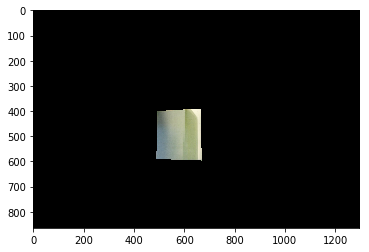

In [62]:
# checking the mask from the provided GT by the organizers



#processing the polygone and creating a mask
def get_mask_raw_data(img_shape, poly,display=False):
    output_mask = np.zeros(img_shape[:2], dtype=np.uint8)
    print('poly',poly)

    coords =  zip(*[iter(poly)] * 2) 
     
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    x = []
    y = []
    polygons = []

    for pt in coords:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    proc_polygons=np.vstack((x,y)).T
    x,y,w,h = cv2.boundingRect(proc_polygons) 
    draw.polygon(xy=polygons, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    if display:
        plt.imshow(mask)
        plt.show
    return mask
for i in range(444,446):#len(df)):

    img=cv2.imread(df_all['img_path'][i])
    row=img.shape[0]
    col=img.shape[1]
    img_shape = (row,col)
    #outer_poly=df['Label'][i] 
    inner_poly=df_all['raw_inner_poly'][i]
    if inner_poly:
        print('raw_inner_poly',inner_poly)
    #outer_mask=get_mask(img_shape,outer_poly,display=False)
        inner_mask=get_mask_raw_data(img_shape,inner_poly,display=False)
        inner_mask.dtype='uint8'
    #outer_mask.dtype='uint8'
    #final_mask=cv2.subtract(outer_mask,inner_mask)
        plt.imshow(cv2.bitwise_and(img,img,mask=inner_mask))
        plt.show
    else:
        print('polygon data corruption detected for index:', i)

test_id=1
test_poly=df['Label'][test_id]['Outer Border']#df['outer_poly'][1] 


In [63]:
#convert the polygons into a format that can be convereted to bounding boxes 
from tqdm import tqdm
#preprocessing our_dataset

def convert_coordinates(poly):
    proc_poly=poly[0]['geometry']
    nums =  re.findall(r'\d+(?:\.\d*)?', proc_poly.rpartition(',')[0])
    coords =  zip(*[iter(nums)] * 2)
    polygons = []
    for pt in coords:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
    
    return polygons 
def convert_coordinates_raw(polygon):
    poly=[]
    polygon =  zip(*[iter(polygon)] * 2)
    for p in polygon:
        poly.append(p)
    return poly
def get_bbox(polygon):
    polygon=polygon[0]['geometry']
    polygon=(polygon)

    polygon =  re.findall(r'\d+(?:\.\d*)?', polygon)
    polygon =  zip(*[iter(polygon)] * 2)
    x = []
    y = []
    for pt in polygon:
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    polygons=np.vstack((x,y)).T
   
    x,y,w,h = cv2.boundingRect(polygons)
    x_min=x
    y_min=y
    x_max=x+w
    y_max=y+h
    return x_min,y_min,x_max,y_max
    #return x_min,x_max,y_min,y_max
def get_bbox_raw_data(polygon):
    polygon =  zip(*[iter(polygon)] * 2)
    x = []
    y = []
    for pt in polygon:
 
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    polygons=np.vstack(((x,y))).T
    
    x,y,w,h = cv2.boundingRect(polygons)
    x_min=x
    y_min=y
    x_max=x+w
    y_max=y+h
    return x_min,y_min,x_max,y_max
    #return x_min,x_max,y_min,y_max
for i in tqdm(range(0,len(df_all))):
    #remove white spaces from image path
   
    df_all['img_path'][i]=re.sub(r"\s+", "", df_all['img_path'][i]) # \s matches all white spaces
    if df_all['raw_inner_poly'][i]:
   
        outer_poly=df_all['Label'][i]['Outer Border']
        inner_poly=df_all['raw_inner_poly'][i]#df['Label'][i]['inner flyable area']
        if inner_poly and outer_poly:
            df_all['outer_poly'][i] = convert_coordinates(outer_poly)
            df_all['inner_poly'][i] = convert_coordinates_raw(inner_poly)
            #df['inner_poly'][i] = convert_coordinates(inner_poly)

            df_all['outer_x_min'][i],df_all['outer_y_min'][i], df_all['outer_x_max'][i],df_all['outer_y_max'][i]=get_bbox(outer_poly)
            df_all['inner_x_min'][i],df_all['inner_y_min'][i], df_all['inner_x_max'][i],df_all['inner_y_max'][i]=get_bbox_raw_data(inner_poly)
            #df_all['outer_x_min'][i],df_all['outer_x_max'][i], df_all['outer_y_min'][i],df_all['outer_y_max'][i]=get_bbox(outer_poly)
            #df_all['inner_x_min'][i],df_all['inner_x_max'][i], df_all['inner_y_min'][i],df_all['inner_y_max'][i]=get_bbox_raw_data(inner_poly) 
    else:
        print('corrupt data detected for index:', i )
        continue
    #df['outer_poly']= h
   #df['inner_poly']= convert_coordinates(inner_poly)



  0%|          | 0/2534 [00:00<?, ?it/s]

  6%|▌         | 148/2534 [00:00<00:01, 1473.01it/s]

 12%|█▏        | 295/2534 [00:00<00:01, 1471.91it/s]

 17%|█▋        | 423/2534 [00:00<00:01, 1407.59it/s]

 22%|██▏       | 554/2534 [00:00<00:01, 1375.09it/s]

 26%|██▌       | 657/2534 [00:00<00:01, 1220.84it/s]

 31%|███       | 776/2534 [00:00<00:01, 1208.82it/s]

 35%|███▌      | 892/2534 [00:00<00:01, 1192.26it/s]

 41%|████      | 1035/2534 [00:00<00:01, 1252.27it/s]

 46%|████▌     | 1154/2534 [00:00<00:01, 1232.27it/s]

 50%|█████     | 1273/2534 [00:01<00:01, 1193.01it/s]

 55%|█████▌    | 1402/2534 [00:01<00:00, 1219.26it/s]

 60%|██████    | 1523/2534 [00:01<00:00, 1215.34it/s]

 65%|██████▍   | 1644/2534 [00:01<00:00, 1173.00it/s]

 70%|██████▉   | 1766/2534 [00:01<00:00, 1186.42it/s]

 74%|███████▍  | 1885/2534 [00:01<00:00, 1180.13it/s]

 79%|███████▉  | 2003/2534 [00:01<00:00, 1156.34it/s]

 84%|████████▎ | 2119/2534 [00:01<00:00, 1142.67it/s]

 88%|████████▊ | 2242/2534 [

In [64]:
df_all.head()

images                                           img_path  \
0  IMG_0015.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
1  IMG_0158.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
2  IMG_0244.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
3  IMG_0367.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   
4  IMG_0374.JPG  /media/a/D/lockheed-martin/dataset/LM_dataset/...   

                                               Label  \
0  {'Outer Border': [{'geometry': 'POLYGON ((997 ...   
1  {'Outer Border': [{'geometry': 'POLYGON ((894 ...   
2  {'Outer Border': [{'geometry': 'POLYGON ((848 ...   
3  {'Outer Border': [{'geometry': 'POLYGON ((597 ...   
4  {'Outer Border': [{'geometry': 'POLYGON ((359 ...   

                             raw_inner_poly  \
0  [504, 191, 902, 177, 915, 580, 495, 584]   
1  [454, 212, 803, 221, 808, 552, 454, 566]   
2  [590, 376, 791, 371, 794, 589, 577, 601]   
3  [836, 385, 641, 387, 635, 582, 841, 582]   
4  [470, 221, 848, 231, 851, 613, 457, 609]   

                                         outer_poly  \
0  [(997, 65), (1014, 683), (402, 673), (416, 106)]   
1  [(894, 638), (375, 646), (383, 136), (882, 141)]   
2  [(848, 312), (851, 649), (533, 639), (538, 328)]   
3  [(597, 623), (880, 627), (881, 344), (603, 346)]   
4  [(359, 703), (950, 711), (943, 141), (384, 128)]   

                                         inner_poly outer_x_min outer_y_min  \
0  [(504, 191), (902, 177), (915, 580), (495, 584)]         402          65   
1  [(454, 212), (803, 221), (808, 552), (454, 566)]         375         136   
2  [(590, 376), (791, 371), (794, 589), (577, 601)]         533         312   
3  [(836, 385), (641, 387), (635, 582), (841, 582)]         597         344   
4  [(470, 221), (848, 231), (851, 613), (457, 609)]         359         128   

  outer_x_max outer_y_max inner_x_min inner_y_min inner_x_max inner_y_max  \
0        1015         684         495         177         916         585   
1         895         647         454         212         809         567   
2         852         650         577         371         795         602   
3         882         628         635         385         842         583   
4         951         712         457         221         852         614   

  class_id  
0           
1           
2           
3           
4

In [65]:
#keep only filed required by yolov3. Divide the dataframe into outer and inner bounding boxes and then assign a class to each one of them 
keep_cols_outer=['img_path', 'outer_x_min', 'outer_y_min', 'outer_x_max', 'outer_y_max','outer_poly','class_id']
keep_cols_inner=['img_path', 'inner_x_min', 'inner_y_min', 'inner_x_max', 'inner_y_max', 'inner_poly','class_id']
df_outer=df_all[keep_cols_outer]
df_inner=df_all[keep_cols_inner]
df_outer['class_id']=0
df_inner['class_id']=1
df_enet=pd.merge(df_outer, df_inner, on='img_path')
df_enet.head()

img_path outer_x_min outer_y_min  \
0  /media/a/D/lockheed-martin/dataset/LM_dataset/...         402          65   
1  /media/a/D/lockheed-martin/dataset/LM_dataset/...         375         136   
2  /media/a/D/lockheed-martin/dataset/LM_dataset/...         533         312   
3  /media/a/D/lockheed-martin/dataset/LM_dataset/...         597         344   
4  /media/a/D/lockheed-martin/dataset/LM_dataset/...         359         128   

  outer_x_max outer_y_max                                        outer_poly  \
0        1015         684  [(997, 65), (1014, 683), (402, 673), (416, 106)]   
1         895         647  [(894, 638), (375, 646), (383, 136), (882, 141)]   
2         852         650  [(848, 312), (851, 649), (533, 639), (538, 328)]   
3         882         628  [(597, 623), (880, 627), (881, 344), (603, 346)]   
4         951         712  [(359, 703), (950, 711), (943, 141), (384, 128)]   

   class_id_x inner_x_min inner_y_min inner_x_max inner_y_max  \
0           0         495         177         916         585   
1           0         454         212         809         567   
2           0         577         371         795         602   
3           0         635         385         842         583   
4           0         457         221         852         614   

                                         inner_poly  class_id_y  
0  [(504, 191), (902, 177), (915, 580), (495, 584)]           1  
1  [(454, 212), (803, 221), (808, 552), (454, 566)]           1  
2  [(590, 376), (791, 371), (794, 589), (577, 601)]           1  
3  [(836, 385), (641, 387), (635, 582), (841, 582)]           1  
4  [(470, 221), (848, 231), (851, 613), (457, 609)]           1

outer poly [(537, 272), (903, 291), (909, 659), (535, 669)]
inner_poly [(582, 324), (831, 342), (843, 584), (589, 590)]
outer poly [(403, 160), (385, 742), (908, 715), (905, 214), (515, 160), (403, 147)]
inner_poly [(476, 243), (820, 285), (825, 639), (470, 649)]
outer poly [(201, 185), (688, 150), (679, 723), (198, 677)]
inner_poly [(279, 255), (603, 247), (597, 627), (278, 604)]
outer poly [(411, 255), (732, 269), (735, 585), (408, 589)]
inner_poly [(461, 312), (677, 316), (689, 539), (464, 532)]
outer poly [(234, 13), (831, 147), (858, 726), (171, 739)]
inner_poly [(319, 146), (737, 219), (751, 632), (292, 623)]
outer poly [(579, 272), (890, 274), (899, 586), (589, 598)]
inner_poly [(627, 323), (839, 321), (843, 535), (630, 542)]
outer poly [(351, 64), (977, 56), (1003, 693), (337, 700)]
inner_poly [(440, 165), (879, 169), (884, 584), (437, 590)]
outer poly [(459, 377), (562, 357), (564, 569), (458, 556)]
inner_poly [(483, 402), (540, 397), (540, 527), (489, 521)]
outer poly [(567, 

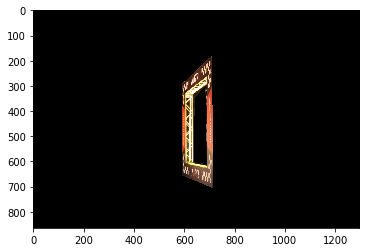

In [66]:
# testing annotation all together 

def get_mask(img_shape, poly,display=False):
     

    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    polygons = []
    for pt in poly:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
    
    draw.polygon(xy=polygons, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    if display:
        plt.imshow(mask)
        plt.show
    return mask
#getting the final mask

for i in range(100,110):#len(df)): # use one image only for testing

    img=cv2.imread(df_enet['img_path'][i])
    row=img.shape[0]
    col=img.shape[1]
    img_shape = (row,col)
    outer_poly=df_enet['outer_poly'][i] 
    print('outer poly',outer_poly)
    inner_poly=df_enet['inner_poly'][i]
    print('inner_poly', list(inner_poly))
    outer_mask=get_mask(img_shape,outer_poly,display=False)
    inner_mask=get_mask(img_shape,inner_poly,display=False)
    inner_mask.dtype='uint8'
    outer_mask.dtype='uint8'
    final_mask=cv2.subtract(outer_mask,inner_mask)
    plt.imshow(cv2.bitwise_and(img,img,mask=final_mask))
    plt.show

In [67]:
print(len(df_enet))

2534


Create the ENet model
We decided to to split the model to three sub classes:

1) Initial block

2) RDDNeck - class for regular, downsampling and dilated bottlenecks

3) ASNeck - class for asymetric bottlenecks

4) UBNeck - class for upsampling bottlenecks

In [13]:
class InitialBlock(nn.Module):
  
  # Initial block of the model:
  #         Input
  #        /     \
  #       /       \
  #maxpool2d    conv2d-3x3
  #       \       /  
  #        \     /
  #      concatenate
   
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        
        side = self.maxpool(x)
        
        # concatenating on the channels axis
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

In [14]:
class UBNeck(nn.Module):
    
  # Upsampling bottleneck:
  #     Bottleneck Input
  #        /        \
  #       /          \
  # conv2d-1x1     convTrans2d-1x1
  #      |             | PReLU
  #      |         convTrans2d-3x3
  #      |             | PReLU
  #      |         convTrans2d-1x1
  #      |             |
  # maxunpool2d    Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  #  Params: 
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        # This layer used for Upsampling
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # summing the main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [15]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
      
  # Regular|Dilated|Downsampling bottlenecks:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  # maxpooling2d   conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-3x3
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params: 
  #  dilation (bool) - if True: creating dilation bottleneck
  #  down_flag (bool) - if True: creating downsampling bottleneck
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  #  p - dropout ratio
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag
        
        # calculating the number of reduced channels
        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [16]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
      
  # Asymetric bottleneck:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  #      |         conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-1x5
  #      |             |
  #      |         conv2d-5x1
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params:    
  #  projection_ratio - ratio between input and output channels
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [17]:
class ENet(nn.Module):
  
  # Creating Enet model!
  
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        # C - number of classes
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        return x

In [18]:
#Instantiate the ENet model
load_pretrained = False
enet = ENet(2)
if load_pretrained:
    state_dict = torch.load('content_256/ckpt-enet-440.pth')['state_dict']
    enet.load_state_dict(state_dict)
    print('loaded a pretrained model')

In [19]:
# Checking if there is any gpu available and pass the model to gpu or cpu
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
enet = enet.to(device)

In [20]:
img = plt.imread(df_enet['img_path'][8])
print(img.shape)

(864, 1296, 3)


In [24]:
#build a generater
from ImgAugumentation import ImgAugumentation
img_augumentation = ImgAugumentation()
def loader(df, batch_size, im_size=(256,256), aug=False):
    total_files_s=len(df)
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    idx = 0
    while(1):
      # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
   
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
          # Reading normalized photo
        
 
            img = plt.imread(df['img_path'][jj])
            orginal_im_size=img.shape
          # Resizing using nearest neighbor method
            img = cv2.resize(img, (im_size[0], im_size[1]), cv2.INTER_NEAREST)
            
          # creating semantic mask 
            outer_poly=df['outer_poly'][jj] 
            #print('outer poly',outer_poly)
            inner_poly=df['inner_poly'][jj]
            #print('inner_poly', list(inner_poly))
            outer_mask=get_mask((orginal_im_size[0], orginal_im_size[1]),outer_poly,display=False)
            inner_mask=get_mask((orginal_im_size[0], orginal_im_size[1]),inner_poly,display=False)
            inner_mask.dtype='uint8'
            outer_mask.dtype='uint8'
            final_mask=cv2.subtract(outer_mask,inner_mask)
          # Resizing using nearest neighbor method
            final_mask = cv2.resize(final_mask, (im_size[0], im_size[1]), cv2.INTER_NEAREST)
            if aug:
                rand_value_augument = np.random.randint(7)
                if (rand_value_augument == 0):   
                    img, final_mask=img_augumentation.flip_image_horz(img, final_mask)
                if (rand_value_augument == 1): 
                    img, final_mask=img_augumentation.flip_image_ver(img, final_mask)
                if (rand_value_augument == 2) or (rand_value_augument == 3): 
                    img=img_augumentation.brightness_images(img)
                if (rand_value_augument == 4): 
                    img, final_mask =img_augumentation.trans_image(img,final_mask,50)
                if (rand_value_augument == 5): 
                    img, final_mask =img_augumentation.stretch_image(img, final_mask,-100)
                if (rand_value_augument == 6): 
                    img, final_mask =img_augumentation.stretch_image(img, final_mask,-50)
                if (rand_value_augument == 7): 
                    img, final_mask =img_augumentation.stretch_image(img, final_mask,+30)
            inputs.append(img)
            labels.append(final_mask)

        inputs = np.stack(inputs, axis=2)
      # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

torch.Size([256, 256])


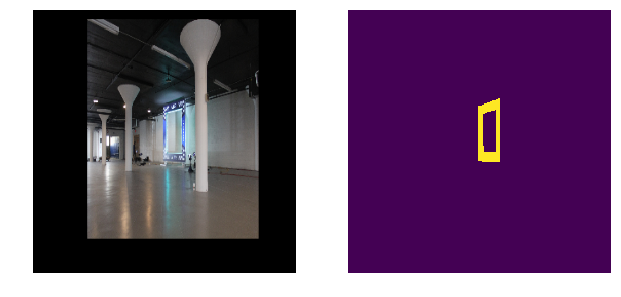

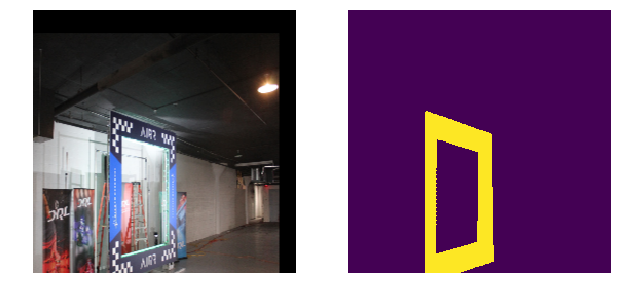

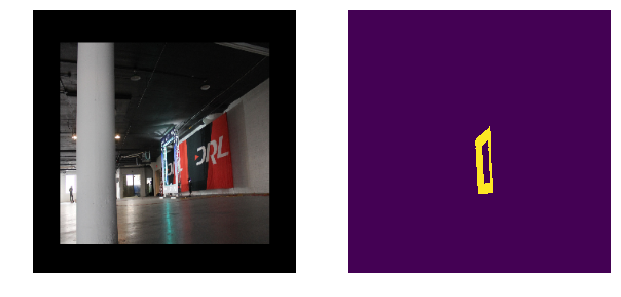

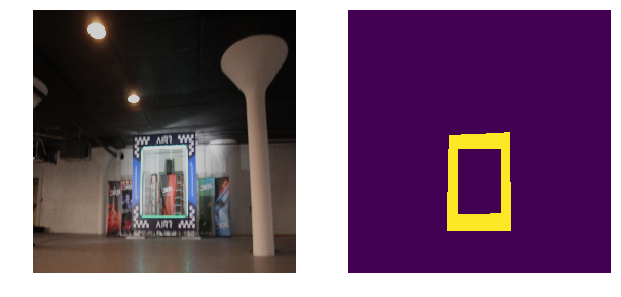

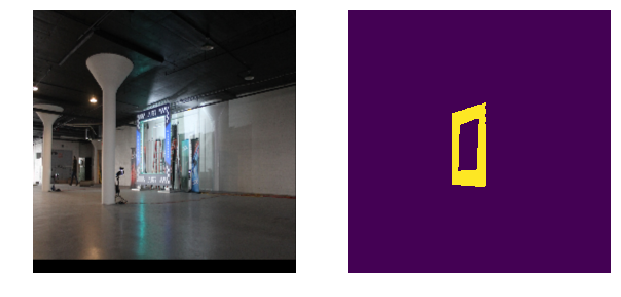

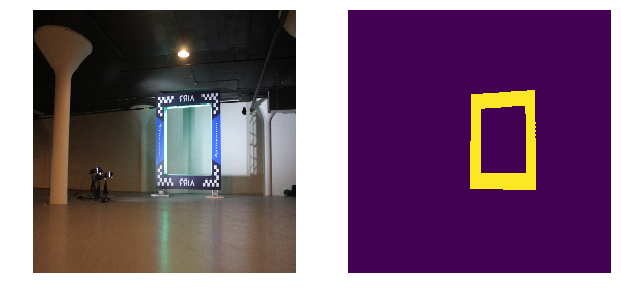

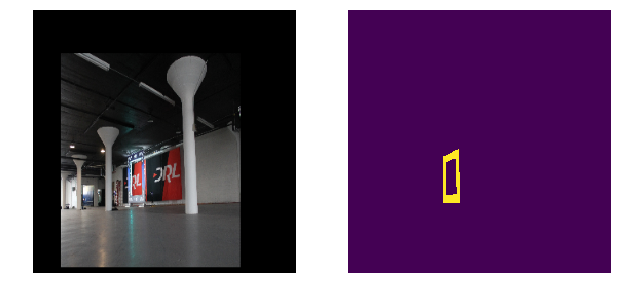

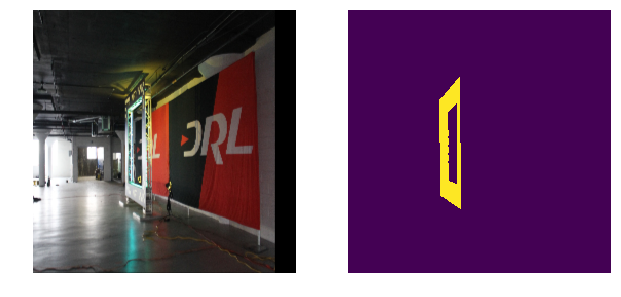

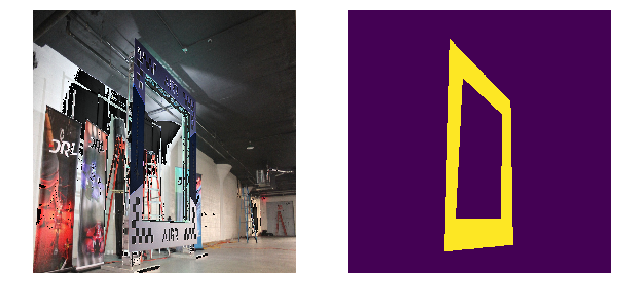

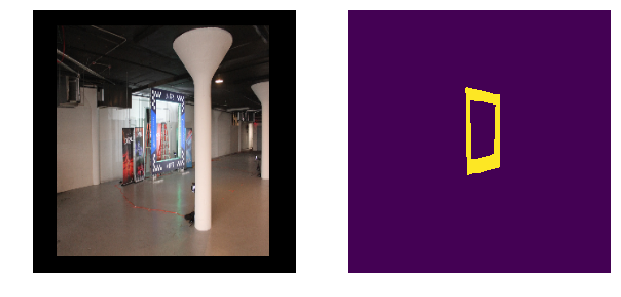

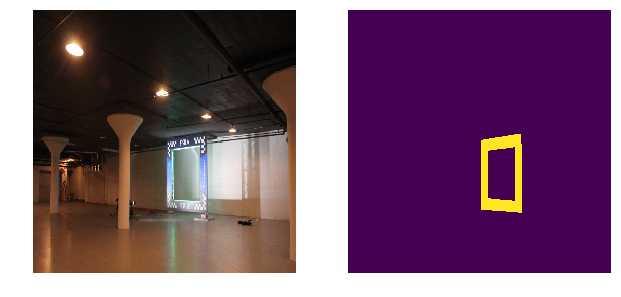

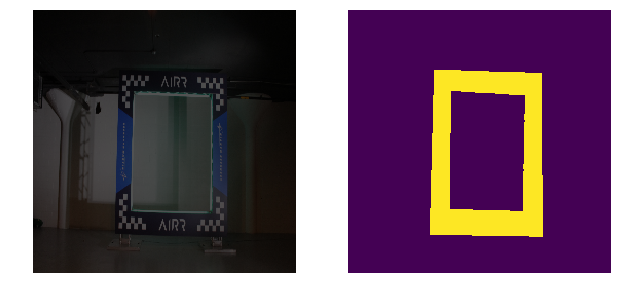

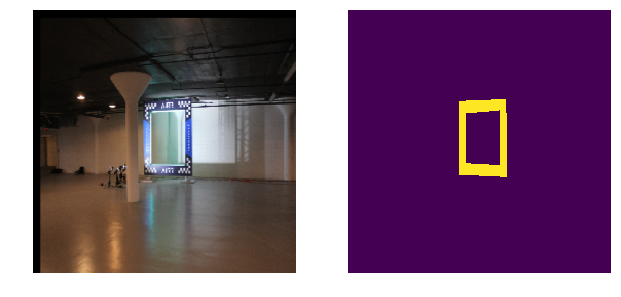

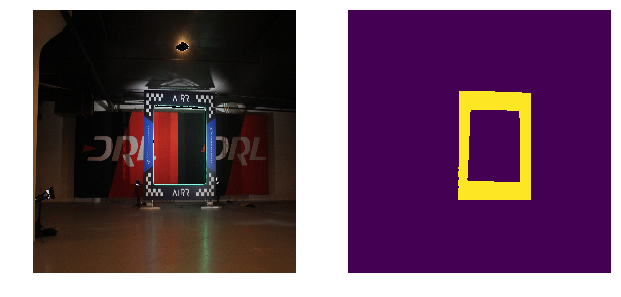

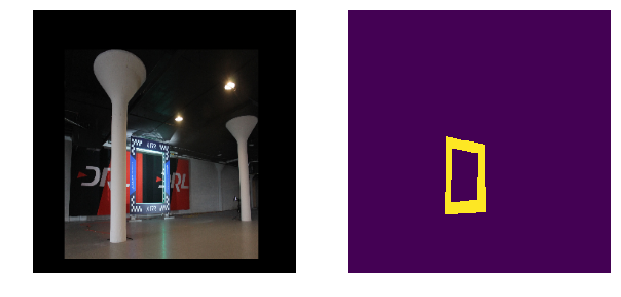

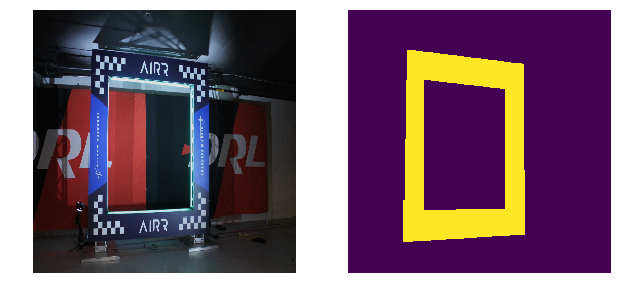

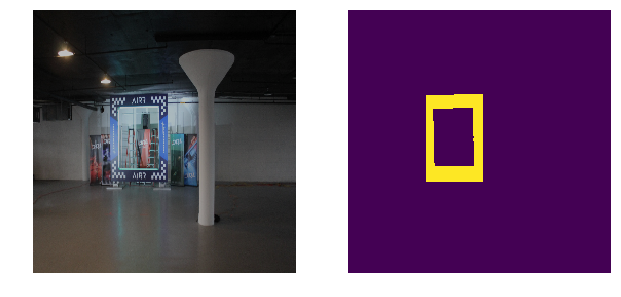

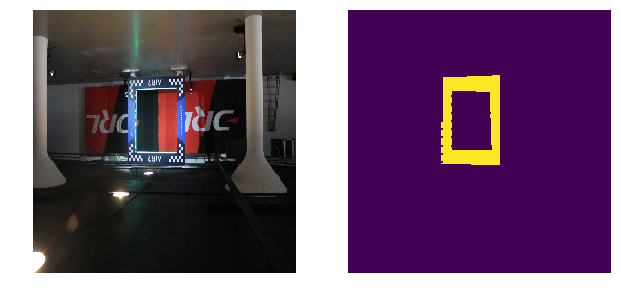

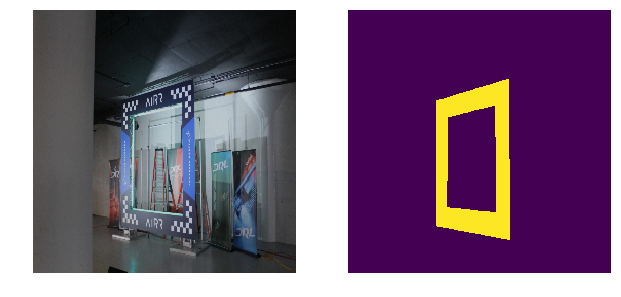

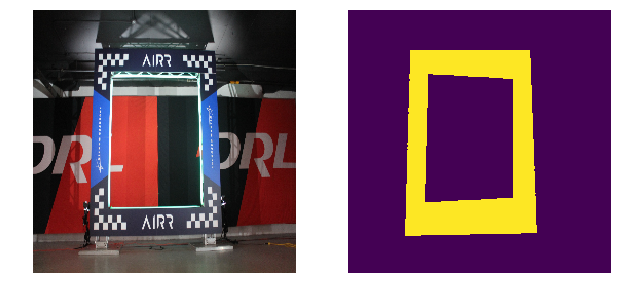

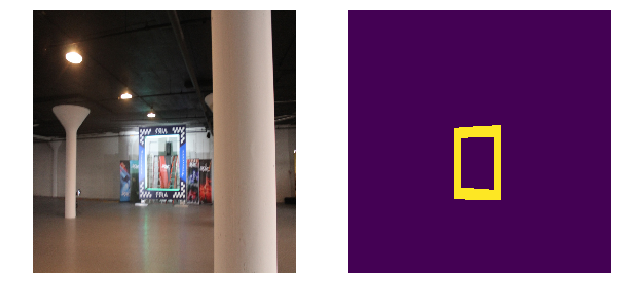

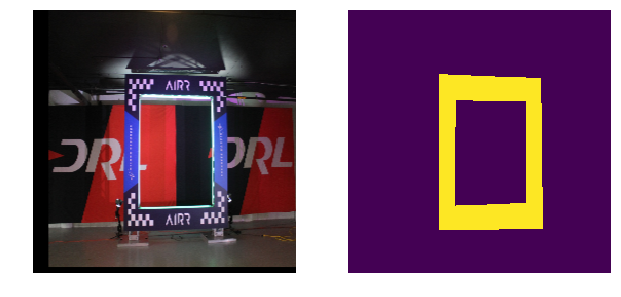

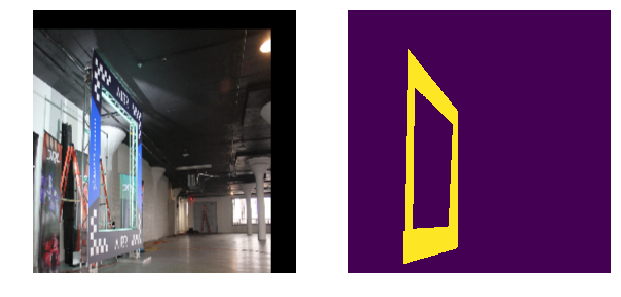

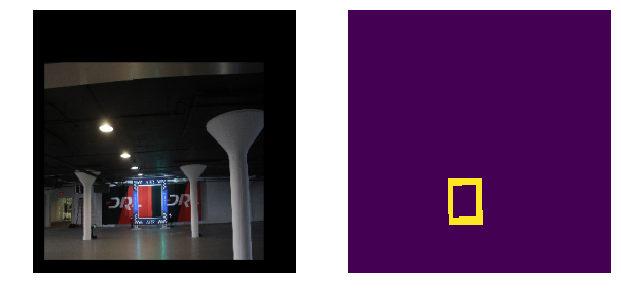

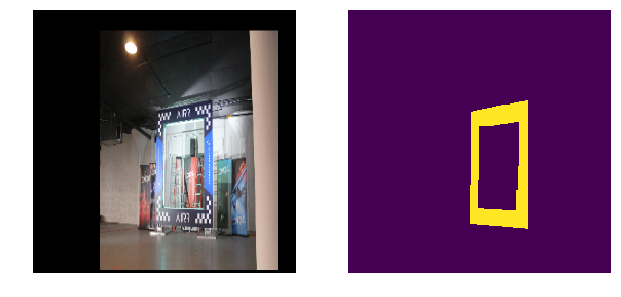

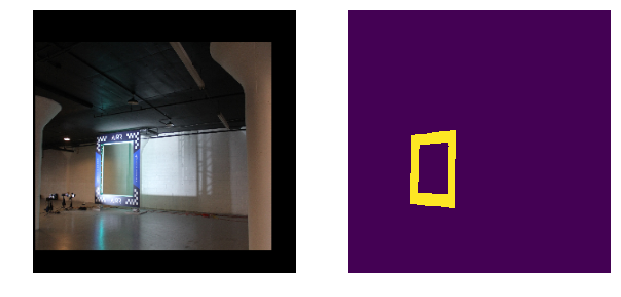

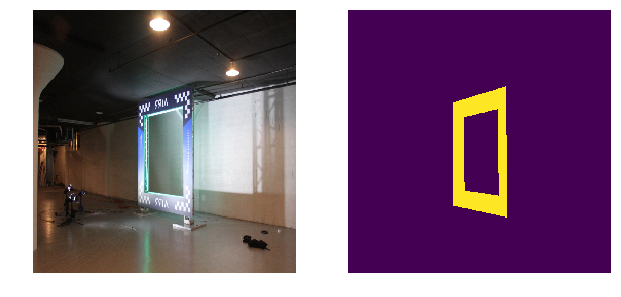

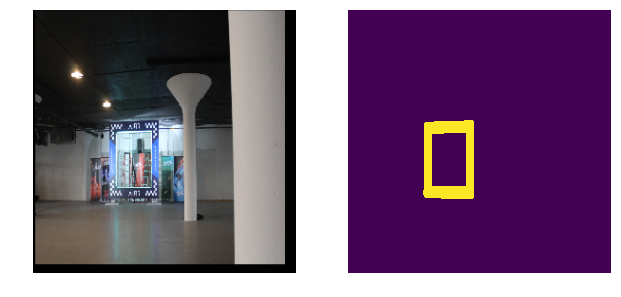

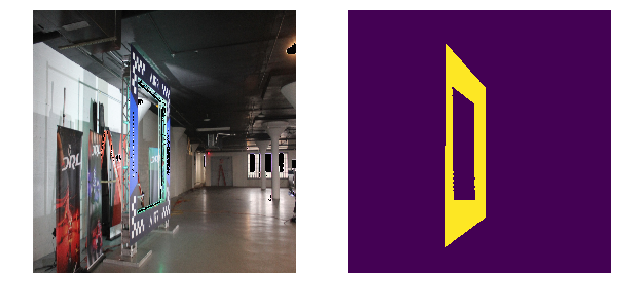

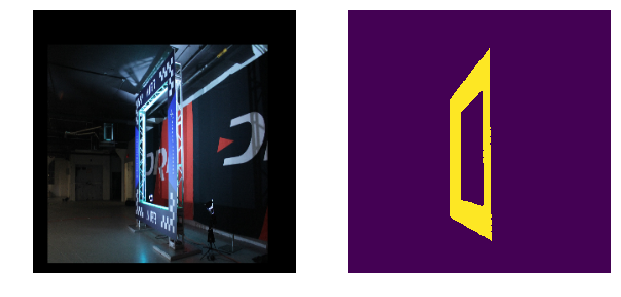

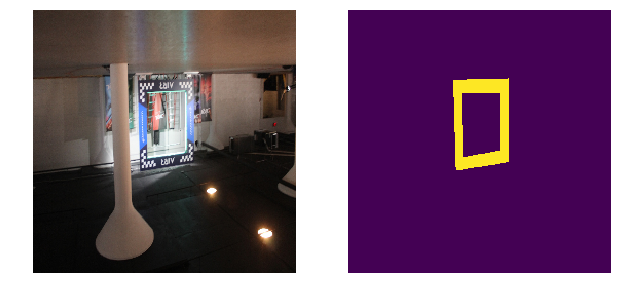

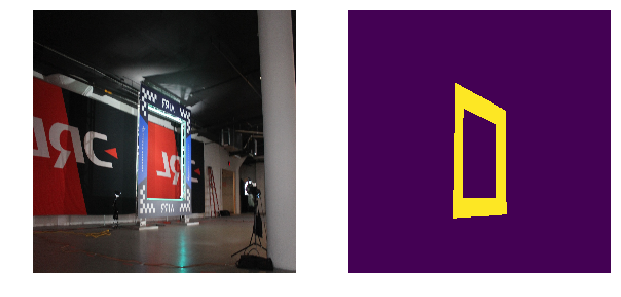

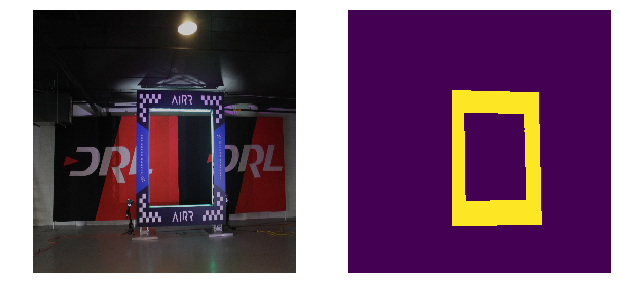

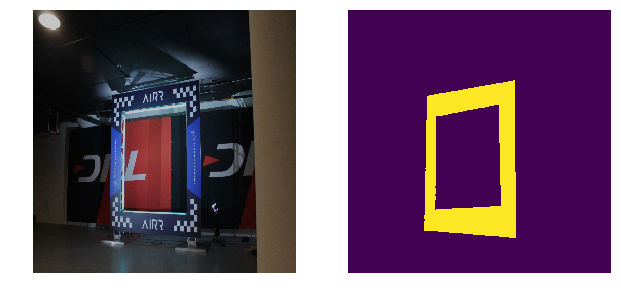

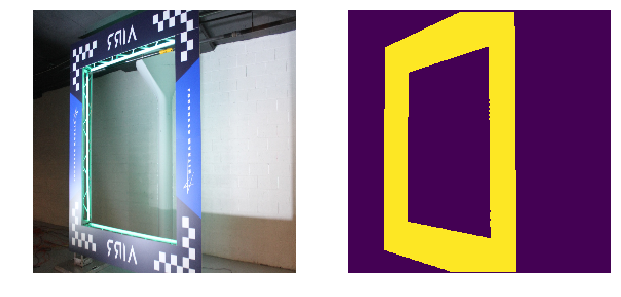

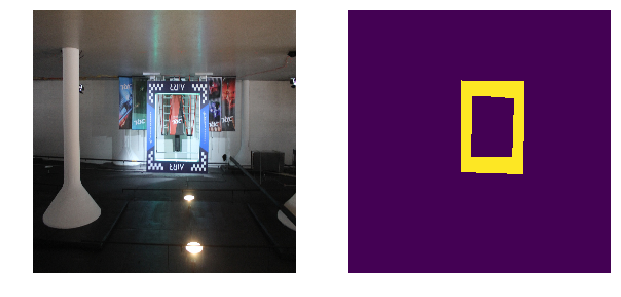

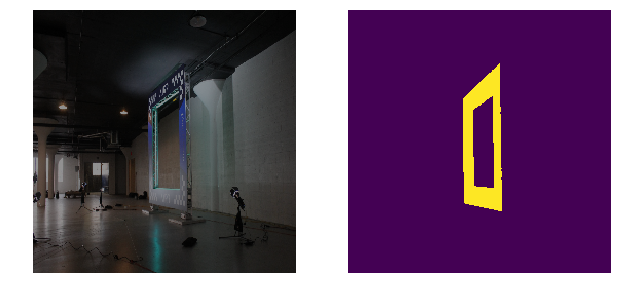

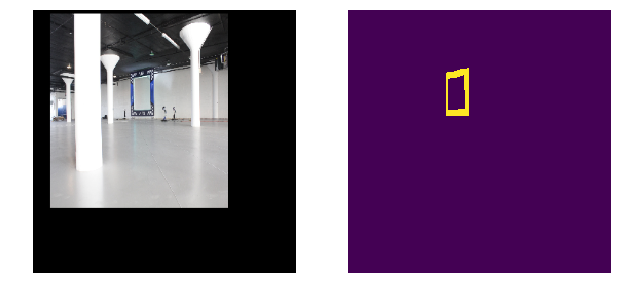

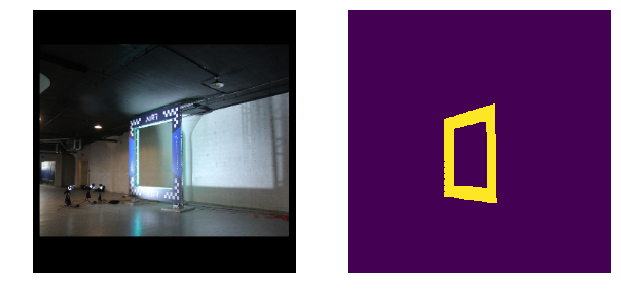

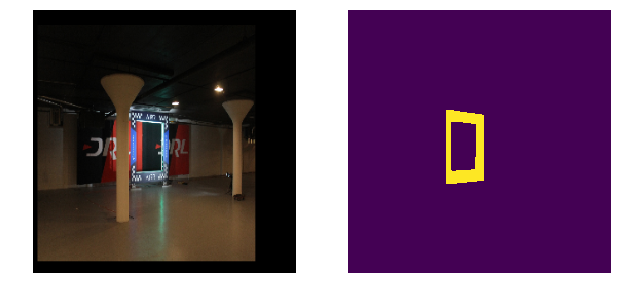

In [23]:
#test the generater
batch_size=40
training_gen=loader(df_enet, batch_size, aug=True)
batch_img,batch_mask = next(training_gen)
print(batch_mask[0].shape)

for i in range(0,len(batch_img)):
 
    plt.figure(figsize=(16,16))
    plt.subplot(1,3,1)
    plt.imshow(batch_img[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(batch_mask[i])
    plt.axis('off')

    plt.show();

In [25]:
def get_class_weights(num_classes, c=1.02):
    pipe = loader(df_enet, batch_size='all',aug=True)
    _, labels = next(pipe)
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [26]:
class_weights = get_class_weights(1)


In [27]:
print(class_weights)

[  1.4869209   12.86811341]


In [28]:
lr = 5e-4
batch_size = 80

criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=2e-4)

print_every = 20
eval_every = 40

In [68]:
print(len(df_enet))

2534


In [69]:
#splitting the dataset into training and testing
from sklearn.model_selection import train_test_split
df_trn, df_tst = train_test_split(df_enet, test_size=0.03)
print(len(df_trn))
print(len(df_tst))


2457
77


In [70]:
df_trn.reset_index(drop=True, inplace=True)
df_tst.reset_index(drop=True, inplace=True)
df_trn.head()

img_path outer_x_min outer_y_min  \
0  /media/a/D/lockheed-martin/dataset/LM_dataset/...         413         326   
1  /media/a/D/lockheed-martin/dataset/LM_dataset/...         345         182   
2  /media/a/D/lockheed-martin/dataset/LM_dataset/...         658         224   
3  /media/a/D/lockheed-martin/dataset/LM_dataset/...         448         427   
4  /media/a/D/lockheed-martin/dataset/LM_dataset/...         589         179   

  outer_x_max outer_y_max                                        outer_poly  \
0         743         684  [(421, 326), (735, 356), (742, 678), (413, 683)]   
1         917         742  [(356, 183), (907, 182), (916, 741), (345, 739)]   
2         805         786  [(658, 383), (787, 224), (804, 785), (658, 759)]   
3         584         634  [(448, 442), (580, 427), (583, 633), (449, 626)]   
4         714         707  [(589, 294), (709, 179), (713, 706), (592, 655)]   

   class_id_x inner_x_min inner_y_min inner_x_max inner_y_max  \
0           0         464         383         685         626   
1           0         428         262         820         650   
2           0         703         355         778         695   
3           0         475         464         559         597   
4           0         637         302         688         612   

                                         inner_poly  class_id_y  
0  [(470, 383), (680, 404), (684, 622), (464, 625)]           1  
1  [(442, 262), (817, 264), (819, 649), (428, 644)]           1  
2  [(705, 414), (772, 355), (777, 694), (703, 694)]           1  
3  [(475, 473), (556, 464), (558, 596), (476, 594)]           1  
4  [(642, 345), (682, 302), (687, 611), (637, 601)]           1

#create overfitting dataset
df_trn, df_tst = train_test_split(df_tst, test_size=0.1)
print(len(df_trn))
print(len(df_tst))
df_trn.reset_index(drop=True, inplace=True)
df_tst.reset_index(drop=True, inplace=True)
df_trn.head()

In [ ]:
train_losses = []
eval_losses = []

bc_train = 100# 1 // batch_size # mini_batch train
bc_eval = 77# // batch_size  # mini_batch validation

# Define pipeline objects
pipe = loader(df_trn, batch_size,aug=True)
eval_pipe = loader(df_tst, batch_size)

epochs = 1000

# Train loop

for e in range(1, epochs+1):
    
    
    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    
    enet.train()
    
    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)
        
        # assign data to cpu/gpu
        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        optimizer.zero_grad()

        out = enet(X_batch.float())
        #print(out.shape)
        # loss calculation
        loss = criterion(out, mask_batch.long())
        # update weights
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        
    print ()
    train_losses.append(train_loss)
    
    if (e+1) % print_every == 0:
        print ('Epoch {}/{}...'.format(e, epochs),
                'Loss {:6f}'.format(train_loss))
    
    if e % eval_every == 0:
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0

            # Validation loop
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                inputs=inputs.float()
                inputs, labels = inputs.to(device), labels.to(device)
                    
                
                out = enet(inputs)
                
                out = out.data.max(1)[1]
                
                eval_loss += (labels.long() - out.long()).sum()
                
            
            print ()
            print ('Loss {:6f}'.format(eval_loss))
            
            eval_losses.append(eval_loss)
        
    if e % print_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict()
        }
        torch.save(checkpoint, 'content_256/ckpt-enet-{}-{}.pth'.format(e, train_loss))
        print ('Model saved!')

print ('Epoch {}/{}...'.format(e, epochs),
       'Total Mean Loss: {:6f}'.format(sum(train_losses) / epochs))



  0%|          | 0/100 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------




  1%|          | 1/100 [00:02<03:41,  2.24s/it]

  2%|▏         | 2/100 [00:04<03:37,  2.22s/it]

  3%|▎         | 3/100 [00:06<03:32,  2.19s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:32<03:00,  2.13s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:40<02:56,  2.18s/it]

 20%|██        | 20/100 [00:43<02:54,  2.19s/it]

 21%|██


--------------- Epoch 2 ---------------




  1%|          | 1/100 [00:02<03:28,  2.11s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:16<03:15,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

 12%|█▏        | 12/100 [00:25<03:08,  2.14s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

 21%|██


--------------- Epoch 3 ---------------




  1%|          | 1/100 [00:02<03:41,  2.24s/it]

  2%|▏         | 2/100 [00:04<03:40,  2.25s/it]

  3%|▎         | 3/100 [00:06<03:36,  2.23s/it]

  4%|▍         | 4/100 [00:08<03:32,  2.21s/it]

  5%|▌         | 5/100 [00:11<03:28,  2.19s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.10s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:30<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:03,  2.19s/it]

 17%|█▋        | 17/100 [00:36<03:01,  2.19s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:41<02:54,  2.16s/it]

 20%|██        | 20/100 [00:43<02:52,  2.15s/it]

 21%|██


--------------- Epoch 4 ---------------




  1%|          | 1/100 [00:02<03:45,  2.28s/it]

  2%|▏         | 2/100 [00:04<03:41,  2.26s/it]

  3%|▎         | 3/100 [00:06<03:39,  2.26s/it]

  4%|▍         | 4/100 [00:09<03:37,  2.26s/it]

  5%|▌         | 5/100 [00:11<03:35,  2.26s/it]

  6%|▌         | 6/100 [00:13<03:30,  2.24s/it]

  7%|▋         | 7/100 [00:15<03:26,  2.22s/it]

  8%|▊         | 8/100 [00:17<03:24,  2.22s/it]

  9%|▉         | 9/100 [00:20<03:20,  2.21s/it]

 10%|█         | 10/100 [00:22<03:19,  2.22s/it]

 11%|█         | 11/100 [00:24<03:17,  2.21s/it]

 12%|█▏        | 12/100 [00:26<03:14,  2.21s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.15s/it]

 15%|█▌        | 15/100 [00:33<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:35<03:02,  2.17s/it]

 17%|█▋        | 17/100 [00:37<02:59,  2.17s/it]

 18%|█▊        | 18/100 [00:39<02:55,  2.15s/it]

 19%|█▉        | 19/100 [00:41<02:56,  2.17s/it]

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

 21%|██


--------------- Epoch 5 ---------------




  1%|          | 1/100 [00:02<03:35,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:33,  2.18s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:19,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:12,  2.13s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.10s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:34<02:57,  2.11s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:42<02:48,  2.10s/it]

 21%|██


--------------- Epoch 6 ---------------




  1%|          | 1/100 [00:02<03:26,  2.09s/it]

  2%|▏         | 2/100 [00:04<03:24,  2.09s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.09s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:19,  2.10s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:16<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:31<03:01,  2.13s/it]

 16%|█▌        | 16/100 [00:33<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

 21%|██


--------------- Epoch 7 ---------------




  1%|          | 1/100 [00:02<03:29,  2.11s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.16s/it]

 13%|█▎        | 13/100 [00:28<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 8 ---------------




  1%|          | 1/100 [00:02<03:29,  2.12s/it]

  2%|▏         | 2/100 [00:04<03:28,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:28<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 9 ---------------




  1%|          | 1/100 [00:02<03:41,  2.24s/it]

  2%|▏         | 2/100 [00:04<03:39,  2.24s/it]

  3%|▎         | 3/100 [00:06<03:37,  2.24s/it]

  4%|▍         | 4/100 [00:08<03:32,  2.22s/it]

  5%|▌         | 5/100 [00:11<03:29,  2.21s/it]

  6%|▌         | 6/100 [00:13<03:27,  2.20s/it]

  7%|▋         | 7/100 [00:15<03:25,  2.21s/it]

  8%|▊         | 8/100 [00:17<03:23,  2.21s/it]

  9%|▉         | 9/100 [00:19<03:21,  2.22s/it]

 10%|█         | 10/100 [00:22<03:21,  2.24s/it]

 11%|█         | 11/100 [00:24<03:19,  2.24s/it]

 12%|█▏        | 12/100 [00:26<03:14,  2.21s/it]

 13%|█▎        | 13/100 [00:28<03:11,  2.20s/it]

 14%|█▍        | 14/100 [00:30<03:08,  2.19s/it]

 15%|█▌        | 15/100 [00:33<03:05,  2.18s/it]

 16%|█▌        | 16/100 [00:35<03:04,  2.20s/it]

 17%|█▋        | 17/100 [00:37<03:02,  2.20s/it]

 18%|█▊        | 18/100 [00:39<02:59,  2.19s/it]

 19%|█▉        | 19/100 [00:41<02:57,  2.19s/it]

 20%|██        | 20/100 [00:44<02:55,  2.19s/it]

 21%|██


--------------- Epoch 10 ---------------




  1%|          | 1/100 [00:02<03:36,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:35,  2.20s/it]

  3%|▎         | 3/100 [00:06<03:34,  2.21s/it]

  4%|▍         | 4/100 [00:08<03:31,  2.20s/it]

  5%|▌         | 5/100 [00:11<03:28,  2.20s/it]

  6%|▌         | 6/100 [00:13<03:27,  2.21s/it]

  7%|▋         | 7/100 [00:15<03:24,  2.20s/it]

  8%|▊         | 8/100 [00:17<03:21,  2.19s/it]

  9%|▉         | 9/100 [00:19<03:20,  2.20s/it]

 10%|█         | 10/100 [00:22<03:17,  2.19s/it]

 11%|█         | 11/100 [00:24<03:14,  2.18s/it]

 12%|█▏        | 12/100 [00:26<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.14s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:37<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:39<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:41<02:53,  2.14s/it]

 20%|██        | 20/100 [00:43<02:51,  2.15s/it]

 21%|██


--------------- Epoch 11 ---------------




  1%|          | 1/100 [00:02<03:28,  2.11s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.13s/it]

 16%|█▌        | 16/100 [00:33<02:58,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:40<02:55,  2.16s/it]

 20%|██        | 20/100 [00:42<02:53,  2.17s/it]

 21%|██


--------------- Epoch 12 ---------------




  1%|          | 1/100 [00:02<03:35,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]

  3%|▎         | 3/100 [00:06<03:33,  2.20s/it]

  4%|▍         | 4/100 [00:08<03:33,  2.22s/it]

  5%|▌         | 5/100 [00:11<03:28,  2.20s/it]

  6%|▌         | 6/100 [00:13<03:23,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:14,  2.17s/it]

 11%|█         | 11/100 [00:23<03:10,  2.15s/it]

 12%|█▏        | 12/100 [00:26<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:06,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:32<02:59,  2.12s/it]

 16%|█▌        | 16/100 [00:34<02:56,  2.10s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:43<02:50,  2.13s/it]

 21%|██


--------------- Epoch 13 ---------------




  1%|          | 1/100 [00:02<03:31,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.15s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.18s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:03,  2.19s/it]

 17%|█▋        | 17/100 [00:36<03:01,  2.18s/it]

 18%|█▊        | 18/100 [00:39<02:59,  2.19s/it]

 19%|█▉        | 19/100 [00:41<02:57,  2.19s/it]

 20%|██        | 20/100 [00:43<02:56,  2.20s/it]

 21%|██


--------------- Epoch 14 ---------------




  1%|          | 1/100 [00:02<03:39,  2.21s/it]

  2%|▏         | 2/100 [00:04<03:35,  2.20s/it]

  3%|▎         | 3/100 [00:06<03:33,  2.20s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.15s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:30<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:59,  2.18s/it]

 19%|█▉        | 19/100 [00:41<02:57,  2.19s/it]

 20%|██        | 20/100 [00:43<02:55,  2.19s/it]

 21%|██


--------------- Epoch 15 ---------------




  1%|          | 1/100 [00:02<03:31,  2.14s/it]

  2%|▏         | 2/100 [00:04<03:28,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.11s/it]

  4%|▍         | 4/100 [00:30<13:53,  8.69s/it]

  5%|▌         | 5/100 [00:32<10:39,  6.73s/it]

  6%|▌         | 6/100 [00:34<08:24,  5.37s/it]

  7%|▋         | 7/100 [00:36<06:50,  4.41s/it]

  8%|▊         | 8/100 [00:39<05:43,  3.73s/it]

  9%|▉         | 9/100 [00:41<04:57,  3.27s/it]

 10%|█         | 10/100 [00:43<04:25,  2.95s/it]

 11%|█         | 11/100 [00:45<04:04,  2.74s/it]

 12%|█▏        | 12/100 [00:47<03:46,  2.57s/it]

 13%|█▎        | 13/100 [00:50<03:33,  2.45s/it]

 14%|█▍        | 14/100 [00:52<03:24,  2.37s/it]

 15%|█▌        | 15/100 [00:54<03:18,  2.33s/it]

 16%|█▌        | 16/100 [00:56<03:12,  2.29s/it]

 17%|█▋        | 17/100 [00:58<03:06,  2.25s/it]

 18%|█▊        | 18/100 [01:00<03:02,  2.22s/it]

 19%|█▉        | 19/100 [01:03<02:58,  2.20s/it]

 20%|██        | 20/100 [01:05<02:56,  2.21s/it]

 21%|██


--------------- Epoch 16 ---------------




  1%|          | 1/100 [00:02<03:34,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:31,  2.20s/it]

  5%|▌         | 5/100 [00:10<03:29,  2.20s/it]

  6%|▌         | 6/100 [00:13<03:25,  2.19s/it]

  7%|▋         | 7/100 [00:15<03:24,  2.20s/it]

  8%|▊         | 8/100 [00:17<03:23,  2.21s/it]

  9%|▉         | 9/100 [00:19<03:22,  2.22s/it]

 10%|█         | 10/100 [00:22<03:20,  2.23s/it]

 11%|█         | 11/100 [00:24<03:16,  2.21s/it]

 12%|█▏        | 12/100 [00:26<03:13,  2.19s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:08,  2.19s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:35<03:02,  2.17s/it]

 17%|█▋        | 17/100 [00:37<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:39<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:41<02:53,  2.14s/it]

 20%|██        | 20/100 [00:43<02:49,  2.12s/it]

 21%|██


--------------- Epoch 17 ---------------




  1%|          | 1/100 [00:02<03:42,  2.25s/it]

  2%|▏         | 2/100 [00:04<03:41,  2.26s/it]

  3%|▎         | 3/100 [00:06<03:38,  2.25s/it]

  4%|▍         | 4/100 [00:09<03:37,  2.27s/it]

  5%|▌         | 5/100 [00:11<03:35,  2.27s/it]

  6%|▌         | 6/100 [00:13<03:34,  2.28s/it]

  7%|▋         | 7/100 [00:15<03:31,  2.27s/it]

  8%|▊         | 8/100 [00:18<03:27,  2.26s/it]

  9%|▉         | 9/100 [00:20<03:24,  2.25s/it]

 10%|█         | 10/100 [00:22<03:21,  2.24s/it]

 11%|█         | 11/100 [00:24<03:20,  2.25s/it]

 12%|█▏        | 12/100 [00:27<03:16,  2.24s/it]

 13%|█▎        | 13/100 [00:29<03:13,  2.22s/it]

 14%|█▍        | 14/100 [00:31<03:10,  2.21s/it]

 15%|█▌        | 15/100 [00:33<03:08,  2.22s/it]

 16%|█▌        | 16/100 [00:35<03:08,  2.24s/it]

 17%|█▋        | 17/100 [00:38<03:05,  2.24s/it]

 18%|█▊        | 18/100 [00:40<03:03,  2.24s/it]

 19%|█▉        | 19/100 [01:01<10:31,  7.79s/it]

 20%|██        | 20/100 [01:03<08:10,  6.13s/it]

 21%|██


--------------- Epoch 18 ---------------




  1%|          | 1/100 [00:02<03:42,  2.25s/it]

  2%|▏         | 2/100 [00:04<03:39,  2.24s/it]

  3%|▎         | 3/100 [00:06<03:36,  2.23s/it]

  4%|▍         | 4/100 [00:08<03:33,  2.23s/it]

  5%|▌         | 5/100 [00:11<03:32,  2.24s/it]

  6%|▌         | 6/100 [00:13<03:28,  2.21s/it]

  7%|▋         | 7/100 [00:15<03:26,  2.22s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:24<03:15,  2.19s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:08,  2.19s/it]

 15%|█▌        | 15/100 [00:32<03:05,  2.18s/it]

 16%|█▌        | 16/100 [00:35<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:37<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:41<02:54,  2.15s/it]

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

 21%|██


--------------- Epoch 19 ---------------




  1%|          | 1/100 [00:02<03:27,  2.09s/it]

  2%|▏         | 2/100 [00:04<03:26,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:02,  2.10s/it]

 14%|█▍        | 14/100 [00:29<03:00,  2.10s/it]

 15%|█▌        | 15/100 [00:31<02:58,  2.10s/it]

 16%|█▌        | 16/100 [00:33<02:57,  2.11s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

 20%|██        | 20/100 [00:42<02:52,  2.16s/it]

 21%|██


Epoch 19/1000... Loss 2.799765
--------------- Epoch 20 ---------------




  1%|          | 1/100 [00:02<03:30,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:41<02:53,  2.14s/it]

 20%|██        | 20/100 [00:43<02:50,  2.13s/it]

 21%|██


Model saved!
--------------- Epoch 21 ---------------




  1%|          | 1/100 [00:02<03:25,  2.07s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.09s/it]

  3%|▎         | 3/100 [00:06<03:22,  2.09s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:17,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.12s/it]

 10%|█         | 10/100 [00:21<03:09,  2.11s/it]

 11%|█         | 11/100 [00:23<03:07,  2.11s/it]

 12%|█▏        | 12/100 [00:25<03:04,  2.10s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<02:58,  2.10s/it]

 16%|█▌        | 16/100 [00:33<02:57,  2.11s/it]

 17%|█▋        | 17/100 [00:35<02:55,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:52,  2.10s/it]

 19%|█▉        | 19/100 [00:40<02:50,  2.10s/it]

 20%|██        | 20/100 [00:42<02:48,  2.11s/it]

 21%|██


--------------- Epoch 22 ---------------




  1%|          | 1/100 [00:02<03:22,  2.05s/it]

  2%|▏         | 2/100 [00:04<03:21,  2.06s/it]

  3%|▎         | 3/100 [00:06<03:21,  2.07s/it]

  4%|▍         | 4/100 [00:08<03:19,  2.08s/it]

  5%|▌         | 5/100 [00:10<03:19,  2.10s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.13s/it]

  8%|▊         | 8/100 [00:16<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

 10%|█         | 10/100 [00:21<03:14,  2.17s/it]

 11%|█         | 11/100 [00:23<03:13,  2.18s/it]

 12%|█▏        | 12/100 [00:25<03:11,  2.17s/it]

 13%|█▎        | 13/100 [00:27<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:29<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:40<02:57,  2.19s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


--------------- Epoch 23 ---------------




  1%|          | 1/100 [00:02<03:34,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.16s/it]

 13%|█▎        | 13/100 [00:28<03:06,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:48,  2.10s/it]

 21%|██


--------------- Epoch 24 ---------------




  1%|          | 1/100 [00:02<03:31,  2.14s/it]

  2%|▏         | 2/100 [00:04<03:28,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:26,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:17,  2.10s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.11s/it]

 10%|█         | 10/100 [00:21<03:11,  2.12s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:31<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.15s/it]

 20%|██        | 20/100 [00:42<02:52,  2.16s/it]

 21%|██


--------------- Epoch 25 ---------------




  1%|          | 1/100 [00:02<03:33,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.11s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.11s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<03:01,  2.13s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.12s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 26 ---------------




  1%|          | 1/100 [00:02<03:39,  2.21s/it]

  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:16<03:15,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<03:01,  2.13s/it]

 16%|█▌        | 16/100 [00:33<02:57,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.11s/it]

 20%|██        | 20/100 [00:42<02:48,  2.10s/it]

 21%|██


--------------- Epoch 27 ---------------




  1%|          | 1/100 [00:02<03:30,  2.12s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:19,  2.10s/it]

  6%|▌         | 6/100 [00:12<03:17,  2.10s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.13s/it]

  8%|▊         | 8/100 [00:16<03:17,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:33<02:56,  2.10s/it]

 17%|█▋        | 17/100 [00:35<02:54,  2.10s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:50,  2.14s/it]

 21%|██


--------------- Epoch 28 ---------------




  1%|          | 1/100 [00:02<03:38,  2.20s/it]

  2%|▏         | 2/100 [00:04<03:36,  2.21s/it]

  3%|▎         | 3/100 [00:06<03:33,  2.20s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.19s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:16,  2.18s/it]

 11%|█         | 11/100 [00:23<03:14,  2.18s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:52,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:50,  2.11s/it]

 20%|██        | 20/100 [00:43<02:48,  2.10s/it]

 21%|██


--------------- Epoch 29 ---------------




  1%|          | 1/100 [00:02<03:32,  2.14s/it]

  2%|▏         | 2/100 [00:04<03:28,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.12s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:09,  2.11s/it]

 11%|█         | 11/100 [00:23<03:07,  2.10s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:02,  2.10s/it]

 14%|█▍        | 14/100 [00:29<03:00,  2.09s/it]

 15%|█▌        | 15/100 [00:31<02:58,  2.11s/it]

 16%|█▌        | 16/100 [00:33<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:35<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:51,  2.14s/it]

 21%|██


--------------- Epoch 30 ---------------




  1%|          | 1/100 [00:02<03:29,  2.12s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

  3%|▎         | 3/100 [00:25<12:40,  7.85s/it]

  4%|▍         | 4/100 [00:27<09:50,  6.15s/it]

  5%|▌         | 5/100 [00:29<07:51,  4.96s/it]

  6%|▌         | 6/100 [00:31<06:26,  4.11s/it]

  7%|▋         | 7/100 [00:34<05:28,  3.53s/it]

  8%|▊         | 8/100 [00:36<04:47,  3.13s/it]

  9%|▉         | 9/100 [00:38<04:17,  2.83s/it]

 10%|█         | 10/100 [00:40<03:55,  2.61s/it]

 11%|█         | 11/100 [00:42<03:38,  2.46s/it]

 12%|█▏        | 12/100 [00:44<03:28,  2.37s/it]

 13%|█▎        | 13/100 [00:46<03:19,  2.29s/it]

 14%|█▍        | 14/100 [00:49<03:11,  2.23s/it]

 15%|█▌        | 15/100 [00:51<03:07,  2.21s/it]

 16%|█▌        | 16/100 [00:53<03:03,  2.18s/it]

 17%|█▋        | 17/100 [00:55<02:59,  2.17s/it]

 18%|█▊        | 18/100 [00:57<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:59<02:52,  2.13s/it]

 20%|██        | 20/100 [01:01<02:51,  2.14s/it]

 21%|██


--------------- Epoch 31 ---------------




  1%|          | 1/100 [00:02<03:29,  2.12s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:26,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:23,  2.12s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.16s/it]

 13%|█▎        | 13/100 [00:27<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.12s/it]

 20%|██        | 20/100 [00:42<02:49,  2.11s/it]

 21%|██


--------------- Epoch 32 ---------------




  1%|          | 1/100 [00:02<03:29,  2.12s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:15,  2.10s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

 10%|█         | 10/100 [00:21<03:11,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.12s/it]

 16%|█▌        | 16/100 [00:33<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:35<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.11s/it]

 20%|██        | 20/100 [00:42<02:50,  2.14s/it]

 21%|██


--------------- Epoch 33 ---------------




  1%|          | 1/100 [00:02<03:25,  2.07s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.09s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:19,  2.10s/it]

  6%|▌         | 6/100 [00:12<03:17,  2.10s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:18<03:11,  2.11s/it]

 10%|█         | 10/100 [00:21<03:10,  2.11s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<02:58,  2.10s/it]

 16%|█▌        | 16/100 [00:33<02:57,  2.11s/it]

 17%|█▋        | 17/100 [00:35<02:55,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 34 ---------------




  1%|          | 1/100 [00:02<03:29,  2.11s/it]

  2%|▏         | 2/100 [00:04<03:26,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.13s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.14s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:40<02:55,  2.16s/it]

 20%|██        | 20/100 [00:42<02:53,  2.17s/it]

 21%|██


--------------- Epoch 35 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:43<02:51,  2.15s/it]

 21%|██


--------------- Epoch 36 ---------------




  1%|          | 1/100 [00:02<03:26,  2.09s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.09s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.12s/it]

  8%|▊         | 8/100 [00:16<03:15,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.11s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:07,  2.10s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:00,  2.10s/it]

 15%|█▌        | 15/100 [00:31<02:58,  2.10s/it]

 16%|█▌        | 16/100 [00:33<02:56,  2.11s/it]

 17%|█▋        | 17/100 [00:35<02:55,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

 21%|██


--------------- Epoch 37 ---------------




  1%|          | 1/100 [00:02<03:30,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.19s/it]

 10%|█         | 10/100 [00:21<03:16,  2.19s/it]

 11%|█         | 11/100 [00:23<03:15,  2.19s/it]

 12%|█▏        | 12/100 [00:26<03:12,  2.19s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:03,  2.18s/it]

 17%|█▋        | 17/100 [00:36<03:01,  2.18s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:41<02:57,  2.19s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


--------------- Epoch 38 ---------------




  1%|          | 1/100 [00:02<03:30,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:28,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:26,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.15s/it]

  7%|▋         | 7/100 [00:15<03:19,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.18s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 39 ---------------




  1%|          | 1/100 [00:02<03:38,  2.21s/it]

  2%|▏         | 2/100 [00:04<03:35,  2.20s/it]

  3%|▎         | 3/100 [00:06<03:34,  2.21s/it]

  4%|▍         | 4/100 [00:08<03:30,  2.20s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:25,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.11s/it]

 10%|█         | 10/100 [00:21<03:10,  2.11s/it]

 11%|█         | 11/100 [00:23<03:07,  2.11s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:32<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:34<02:57,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:50,  2.11s/it]

 20%|██        | 20/100 [00:42<02:47,  2.10s/it]

 21%|██


Epoch 39/1000... Loss 2.651577
--------------- Epoch 40 ---------------




  1%|          | 1/100 [00:02<03:24,  2.07s/it]

  2%|▏         | 2/100 [00:04<03:23,  2.08s/it]

  3%|▎         | 3/100 [00:06<03:22,  2.09s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:18,  2.09s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:18<03:11,  2.11s/it]

 10%|█         | 10/100 [00:21<03:09,  2.11s/it]

 11%|█         | 11/100 [00:23<03:07,  2.11s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:33<02:57,  2.11s/it]

 17%|█▋        | 17/100 [00:35<02:55,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.15s/it]

 20%|██        | 20/100 [00:42<02:52,  2.15s/it]

 21%|██



  1%|▏         | 1/77 [00:01<02:14,  1.78s/it]

  3%|▎         | 2/77 [00:03<02:12,  1.76s/it]

  4%|▍         | 3/77 [00:05<02:10,  1.76s/it]

  5%|▌         | 4/77 [00:06<02:07,  1.75s/it]

  6%|▋         | 5/77 [00:08<02:06,  1.76s/it]

  8%|▊         | 6/77 [00:10<02:04,  1.75s/it]

  9%|▉         | 7/77 [00:12<02:02,  1.75s/it]

 10%|█         | 8/77 [00:14<02:00,  1.75s/it]

 12%|█▏        | 9/77 [00:15<01:58,  1.75s/it]

 13%|█▎        | 10/77 [00:17<01:57,  1.76s/it]

 14%|█▍        | 11/77 [00:19<01:56,  1.77s/it]

 16%|█▌        | 12/77 [00:21<01:54,  1.76s/it]

 17%|█▋        | 13/77 [00:22<01:51,  1.74s/it]

 18%|█▊        | 14/77 [00:24<01:49,  1.74s/it]

 19%|█▉        | 15/77 [00:26<01:48,  1.75s/it]

 21%|██        | 16/77 [00:28<01:47,  1.77s/it]

 22%|██▏       | 17/77 [00:29<01:45,  1.77s/it]

 23%|██▎       | 18/77 [00:31<01:43,  1.75s/it]

 25%|██▍       | 19/77 [00:33<01:40,  1.74s/it]

 26%|██▌       | 20/77 [00:35<01:39,  1.75s/it]

 27%|██▋       | 21/77 [00:


Loss 27842688.000000
Model saved!
--------------- Epoch 41 ---------------




  1%|          | 1/100 [00:02<03:26,  2.08s/it]

  2%|▏         | 2/100 [00:04<03:24,  2.09s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:16<03:15,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:11,  2.11s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.10s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:33<02:58,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 42 ---------------




  1%|          | 1/100 [00:02<03:27,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:26,  2.10s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:19,  2.10s/it]

  6%|▌         | 6/100 [00:12<03:17,  2.10s/it]

  7%|▋         | 7/100 [00:14<03:15,  2.10s/it]

  8%|▊         | 8/100 [00:16<03:13,  2.11s/it]

  9%|▉         | 9/100 [00:18<03:11,  2.11s/it]

 10%|█         | 10/100 [00:21<03:09,  2.11s/it]

 11%|█         | 11/100 [00:23<03:08,  2.11s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.13s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.14s/it]

 15%|█▌        | 15/100 [00:31<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:33<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:40<02:56,  2.18s/it]

 20%|██        | 20/100 [00:42<02:54,  2.18s/it]

 21%|██


--------------- Epoch 43 ---------------




  1%|          | 1/100 [00:02<03:29,  2.11s/it]

  2%|▏         | 2/100 [00:04<03:28,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:24,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:16,  2.18s/it]

 11%|█         | 11/100 [00:23<03:13,  2.18s/it]

 12%|█▏        | 12/100 [00:26<03:12,  2.19s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:08,  2.20s/it]

 15%|█▌        | 15/100 [00:32<03:05,  2.18s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.18s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:39<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:41<02:54,  2.16s/it]

 20%|██        | 20/100 [00:43<02:51,  2.14s/it]

 21%|██


--------------- Epoch 44 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:23,  2.19s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:11,  2.16s/it]

 12%|█▏        | 12/100 [00:26<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:53,  2.16s/it]

 21%|██


--------------- Epoch 45 ---------------




  1%|          | 1/100 [00:02<03:34,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.18s/it]

 15%|█▌        | 15/100 [00:32<03:05,  2.18s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:56,  2.17s/it]

 20%|██        | 20/100 [00:43<02:54,  2.19s/it]

 21%|██


--------------- Epoch 46 ---------------




  1%|          | 1/100 [00:02<03:30,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:26,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:15,  2.10s/it]

  8%|▊         | 8/100 [00:16<03:13,  2.11s/it]

  9%|▉         | 9/100 [00:19<03:11,  2.11s/it]

 10%|█         | 10/100 [00:21<03:09,  2.10s/it]

 11%|█         | 11/100 [00:23<03:07,  2.10s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.13s/it]

 14%|█▍        | 14/100 [00:29<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:31<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.17s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:40<02:55,  2.16s/it]

 20%|██        | 20/100 [00:42<02:52,  2.15s/it]

 21%|██


--------------- Epoch 47 ---------------




  1%|          | 1/100 [00:02<03:26,  2.08s/it]

  2%|▏         | 2/100 [00:04<03:26,  2.10s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.12s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 48 ---------------




  1%|          | 1/100 [00:02<03:34,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.13s/it]

 17%|█▋        | 17/100 [00:58<12:08,  8.78s/it]

 18%|█▊        | 18/100 [01:00<09:14,  6.77s/it]

 19%|█▉        | 19/100 [01:02<07:14,  5.37s/it]

 20%|██        | 20/100 [01:05<05:52,  4.41s/it]

 21%|██


--------------- Epoch 49 ---------------




  1%|          | 1/100 [00:02<03:31,  2.14s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

  3%|▎         | 3/100 [00:06<03:26,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.11s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:33<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

 21%|██


--------------- Epoch 50 ---------------




  1%|          | 1/100 [00:02<03:38,  2.20s/it]

  2%|▏         | 2/100 [00:04<03:36,  2.21s/it]

  3%|▎         | 3/100 [00:06<03:33,  2.20s/it]

  4%|▍         | 4/100 [00:08<03:31,  2.21s/it]

  5%|▌         | 5/100 [00:11<03:28,  2.20s/it]

  6%|▌         | 6/100 [00:13<03:26,  2.19s/it]

  7%|▋         | 7/100 [00:15<03:23,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:26<03:10,  2.16s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:54,  2.16s/it]

 20%|██        | 20/100 [00:43<02:53,  2.16s/it]

 21%|██


--------------- Epoch 51 ---------------




  1%|          | 1/100 [00:02<03:36,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]

  3%|▎         | 3/100 [00:06<03:32,  2.19s/it]

  4%|▍         | 4/100 [00:08<03:30,  2.19s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.17s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:53,  2.17s/it]

 21%|██


--------------- Epoch 52 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.17s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:23,  2.19s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:19,  2.19s/it]

 10%|█         | 10/100 [00:21<03:16,  2.19s/it]

 11%|█         | 11/100 [00:23<03:14,  2.19s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.12s/it]

 20%|██        | 20/100 [00:43<02:49,  2.11s/it]

 21%|██


--------------- Epoch 53 ---------------




  1%|          | 1/100 [00:02<03:29,  2.12s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.16s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:53,  2.17s/it]

 21%|██


--------------- Epoch 54 ---------------




  1%|          | 1/100 [00:02<03:29,  2.12s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.13s/it]

  8%|▊         | 8/100 [00:16<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.16s/it]

 13%|█▎        | 13/100 [00:27<03:08,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.18s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.17s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:40<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

 21%|██


--------------- Epoch 55 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:24,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.16s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:05,  2.18s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.18s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.17s/it]

 18%|█▊        | 18/100 [00:39<02:59,  2.19s/it]

 19%|█▉        | 19/100 [00:41<02:56,  2.17s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


--------------- Epoch 56 ---------------




  1%|          | 1/100 [00:02<03:27,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.10s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:23,  2.12s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:19,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:11,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.18s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:59,  2.19s/it]

 19%|█▉        | 19/100 [00:41<02:56,  2.18s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


--------------- Epoch 57 ---------------




  1%|          | 1/100 [00:02<03:28,  2.11s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:29<14:50,  9.18s/it]

  4%|▍         | 4/100 [00:32<11:18,  7.07s/it]

  5%|▌         | 5/100 [00:34<08:51,  5.59s/it]

  6%|▌         | 6/100 [00:36<07:08,  4.55s/it]

  7%|▋         | 7/100 [00:38<05:56,  3.83s/it]

  8%|▊         | 8/100 [00:40<05:04,  3.30s/it]

  9%|▉         | 9/100 [00:42<04:30,  2.97s/it]

 10%|█         | 10/100 [00:44<04:04,  2.72s/it]

 11%|█         | 11/100 [00:47<03:46,  2.54s/it]

 12%|█▏        | 12/100 [00:49<03:33,  2.43s/it]

 13%|█▎        | 13/100 [00:51<03:23,  2.34s/it]

 14%|█▍        | 14/100 [00:53<03:16,  2.28s/it]

 15%|█▌        | 15/100 [00:55<03:10,  2.24s/it]

 16%|█▌        | 16/100 [00:57<03:05,  2.21s/it]

 17%|█▋        | 17/100 [00:59<03:00,  2.17s/it]

 18%|█▊        | 18/100 [01:01<02:56,  2.15s/it]

 19%|█▉        | 19/100 [01:04<02:53,  2.14s/it]

 20%|██        | 20/100 [01:06<02:50,  2.13s/it]

 21%|██


--------------- Epoch 58 ---------------




  1%|          | 1/100 [00:02<03:25,  2.08s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.10s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:17,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.16s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.17s/it]

 19%|█▉        | 19/100 [00:40<02:56,  2.18s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


--------------- Epoch 59 ---------------




  1%|          | 1/100 [00:02<03:33,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.16s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [01:00<10:38,  7.88s/it]

 20%|██        | 20/100 [01:02<08:14,  6.18s/it]

 21%|██


Epoch 59/1000... Loss 2.635047
--------------- Epoch 60 ---------------




  1%|          | 1/100 [00:02<03:30,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:26,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:27<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.15s/it]

 20%|██        | 20/100 [00:42<02:52,  2.16s/it]

 21%|██


Model saved!
--------------- Epoch 61 ---------------




  1%|          | 1/100 [00:02<03:38,  2.21s/it]

  2%|▏         | 2/100 [00:04<03:35,  2.20s/it]

  3%|▎         | 3/100 [00:06<03:31,  2.18s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.17s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 62 ---------------




  1%|          | 1/100 [00:02<03:26,  2.09s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.15s/it]

  7%|▋         | 7/100 [00:15<03:19,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.18s/it]

 15%|█▌        | 15/100 [00:32<03:05,  2.18s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.18s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:41<02:52,  2.13s/it]

 20%|██        | 20/100 [00:43<02:49,  2.12s/it]

 21%|██


--------------- Epoch 63 ---------------




  1%|          | 1/100 [00:02<03:35,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:33,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.17s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.13s/it]

 14%|█▍        | 14/100 [00:30<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:32<03:00,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:57,  2.11s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 64 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:20<11:24,  6.99s/it]

  3%|▎         | 3/100 [00:22<08:56,  5.54s/it]

  4%|▍         | 4/100 [00:24<07:14,  4.53s/it]

  5%|▌         | 5/100 [00:26<06:04,  3.83s/it]

  6%|▌         | 6/100 [00:29<05:13,  3.34s/it]

  7%|▋         | 7/100 [00:31<04:37,  2.98s/it]

  8%|▊         | 8/100 [00:33<04:11,  2.73s/it]

  9%|▉         | 9/100 [00:35<03:53,  2.56s/it]

 10%|█         | 10/100 [00:37<03:40,  2.45s/it]

 11%|█         | 11/100 [00:39<03:28,  2.35s/it]

 12%|█▏        | 12/100 [00:42<03:21,  2.29s/it]

 13%|█▎        | 13/100 [00:44<03:16,  2.25s/it]

 14%|█▍        | 14/100 [00:46<03:11,  2.23s/it]

 15%|█▌        | 15/100 [00:48<03:07,  2.21s/it]

 16%|█▌        | 16/100 [00:50<03:04,  2.20s/it]

 17%|█▋        | 17/100 [00:52<03:02,  2.20s/it]

 18%|█▊        | 18/100 [00:55<02:59,  2.19s/it]

 19%|█▉        | 19/100 [00:57<02:56,  2.18s/it]

 20%|██        | 20/100 [00:59<02:55,  2.19s/it]

 21%|██


--------------- Epoch 65 ---------------




  1%|          | 1/100 [00:02<03:34,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:10,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.18s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.17s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:53,  2.14s/it]

 20%|██        | 20/100 [00:43<02:51,  2.15s/it]

 21%|██


--------------- Epoch 66 ---------------




  1%|          | 1/100 [00:02<03:30,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:28,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:17,  2.10s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:16<03:15,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.10s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.10s/it]

 14%|█▍        | 14/100 [00:29<03:00,  2.10s/it]

 15%|█▌        | 15/100 [00:31<02:58,  2.10s/it]

 16%|█▌        | 16/100 [00:33<02:57,  2.11s/it]

 17%|█▋        | 17/100 [00:35<02:55,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 67 ---------------




  1%|          | 1/100 [00:02<03:30,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.15s/it]

  7%|▋         | 7/100 [00:15<03:19,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:11,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:30<03:02,  2.13s/it]

 15%|█▌        | 15/100 [00:32<03:00,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:52,  2.10s/it]

 19%|█▉        | 19/100 [00:40<02:49,  2.10s/it]

 20%|██        | 20/100 [00:42<02:48,  2.11s/it]

 21%|██


--------------- Epoch 68 ---------------




  1%|          | 1/100 [00:02<03:27,  2.09s/it]

  2%|▏         | 2/100 [00:04<03:26,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:18,  2.09s/it]

  6%|▌         | 6/100 [00:12<03:17,  2.10s/it]

  7%|▋         | 7/100 [00:14<03:15,  2.10s/it]

  8%|▊         | 8/100 [00:16<03:13,  2.11s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:06,  2.10s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.13s/it]

 16%|█▌        | 16/100 [00:33<02:57,  2.12s/it]

 17%|█▋        | 17/100 [00:35<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 69 ---------------




  1%|          | 1/100 [00:02<03:32,  2.14s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.14s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:19,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.13s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.14s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.13s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:50,  2.10s/it]

 20%|██        | 20/100 [00:42<02:47,  2.10s/it]

 21%|██


--------------- Epoch 70 ---------------




  1%|          | 1/100 [00:02<03:27,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.12s/it]

 10%|█         | 10/100 [00:21<03:09,  2.11s/it]

 11%|█         | 11/100 [00:23<03:09,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<02:59,  2.09s/it]

 15%|█▌        | 15/100 [00:31<02:58,  2.10s/it]

 16%|█▌        | 16/100 [00:33<02:57,  2.11s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:51,  2.14s/it]

 21%|██


--------------- Epoch 71 ---------------




  1%|          | 1/100 [00:02<03:35,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:25,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:24,  2.20s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:10,  2.16s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:41<02:53,  2.14s/it]

 20%|██        | 20/100 [00:43<02:49,  2.12s/it]

 21%|██


--------------- Epoch 72 ---------------




  1%|          | 1/100 [00:02<03:35,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:29<12:31,  7.91s/it]

  6%|▌         | 6/100 [00:32<09:40,  6.18s/it]

  7%|▋         | 7/100 [00:34<07:43,  4.98s/it]

  8%|▊         | 8/100 [00:36<06:21,  4.14s/it]

  9%|▉         | 9/100 [00:38<05:23,  3.55s/it]

 10%|█         | 10/100 [00:40<04:41,  3.12s/it]

 11%|█         | 11/100 [00:42<04:12,  2.84s/it]

 12%|█▏        | 12/100 [00:45<03:52,  2.64s/it]

 13%|█▎        | 13/100 [00:47<03:38,  2.51s/it]

 14%|█▍        | 14/100 [00:49<03:26,  2.40s/it]

 15%|█▌        | 15/100 [00:51<03:17,  2.32s/it]

 16%|█▌        | 16/100 [00:53<03:10,  2.26s/it]

 17%|█▋        | 17/100 [00:55<03:04,  2.22s/it]

 18%|█▊        | 18/100 [00:58<03:00,  2.20s/it]

 19%|█▉        | 19/100 [01:00<02:56,  2.18s/it]

 20%|██        | 20/100 [01:02<02:54,  2.18s/it]

 21%|██


--------------- Epoch 73 ---------------




  1%|          | 1/100 [00:02<03:31,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:28,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:23,  2.12s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:09,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:33<02:56,  2.10s/it]

 17%|█▋        | 17/100 [00:36<02:54,  2.10s/it]

 18%|█▊        | 18/100 [00:38<02:52,  2.10s/it]

 19%|█▉        | 19/100 [00:40<02:50,  2.10s/it]

 20%|██        | 20/100 [00:42<02:48,  2.11s/it]

 21%|██


--------------- Epoch 74 ---------------




  1%|          | 1/100 [00:02<03:36,  2.19s/it]

  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]

  3%|▎         | 3/100 [00:06<03:31,  2.18s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:23,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.13s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:32<02:58,  2.10s/it]

 16%|█▌        | 16/100 [00:34<02:56,  2.10s/it]

 17%|█▋        | 17/100 [00:36<02:54,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

 21%|██


--------------- Epoch 75 ---------------




  1%|          | 1/100 [00:02<03:34,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:31,  2.18s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.17s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:26<03:09,  2.16s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:42<02:48,  2.10s/it]

 21%|██


--------------- Epoch 76 ---------------




  1%|          | 1/100 [00:02<03:28,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:26,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:19,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.15s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:27<03:07,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.17s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

 21%|██


--------------- Epoch 77 ---------------




  1%|          | 1/100 [00:02<03:33,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:19,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:00,  2.10s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.12s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.11s/it]

 20%|██        | 20/100 [00:42<02:49,  2.11s/it]

 21%|██


--------------- Epoch 78 ---------------




  1%|          | 1/100 [00:02<03:34,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.15s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<03:01,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.15s/it]

 20%|██        | 20/100 [00:58<09:22,  7.03s/it]

 21%|██


--------------- Epoch 79 ---------------




  1%|          | 1/100 [00:02<03:34,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.15s/it]

  7%|▋         | 7/100 [00:15<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.14s/it]

 10%|█         | 10/100 [00:21<03:11,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<02:58,  2.10s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.11s/it]

 20%|██        | 20/100 [00:42<02:48,  2.10s/it]

 21%|██


Epoch 79/1000... Loss 2.737407
--------------- Epoch 80 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

 10%|█         | 10/100 [00:21<03:10,  2.11s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.13s/it]

 15%|█▌        | 15/100 [00:31<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

 21%|██



  1%|▏         | 1/77 [00:01<02:17,  1.81s/it]

  3%|▎         | 2/77 [00:03<02:13,  1.78s/it]

  4%|▍         | 3/77 [00:05<02:10,  1.77s/it]

  5%|▌         | 4/77 [00:06<02:08,  1.76s/it]

  6%|▋         | 5/77 [00:08<02:06,  1.76s/it]

  8%|▊         | 6/77 [00:10<02:06,  1.78s/it]

  9%|▉         | 7/77 [00:12<02:04,  1.78s/it]

 10%|█         | 8/77 [00:14<02:02,  1.77s/it]

 12%|█▏        | 9/77 [00:15<02:00,  1.77s/it]

 13%|█▎        | 10/77 [00:17<01:59,  1.78s/it]

 14%|█▍        | 11/77 [00:19<01:58,  1.79s/it]

 16%|█▌        | 12/77 [00:21<01:55,  1.78s/it]

 17%|█▋        | 13/77 [00:23<01:53,  1.78s/it]

 18%|█▊        | 14/77 [00:24<01:50,  1.76s/it]

 19%|█▉        | 15/77 [00:26<01:49,  1.77s/it]

 21%|██        | 16/77 [00:28<01:47,  1.77s/it]

 22%|██▏       | 17/77 [00:30<01:46,  1.78s/it]

 23%|██▎       | 18/77 [00:31<01:43,  1.76s/it]

 25%|██▍       | 19/77 [00:33<01:41,  1.75s/it]

 26%|██▌       | 20/77 [00:35<01:40,  1.76s/it]

 27%|██▋       | 21/77 [00:


Loss 28232259.000000
Model saved!
--------------- Epoch 81 ---------------




  1%|          | 1/100 [00:02<03:29,  2.11s/it]

  2%|▏         | 2/100 [00:04<03:26,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:19,  2.10s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:16<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.14s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:40<02:56,  2.17s/it]

 20%|██        | 20/100 [00:42<02:54,  2.18s/it]

 21%|██


--------------- Epoch 82 ---------------




  1%|          | 1/100 [00:02<03:27,  2.09s/it]

  2%|▏         | 2/100 [00:04<03:26,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:23,  2.12s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:08,  2.14s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:30<03:03,  2.14s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 83 ---------------




  1%|          | 1/100 [00:02<03:27,  2.09s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.10s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:27<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.17s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:40<02:56,  2.18s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


--------------- Epoch 84 ---------------




  1%|          | 1/100 [00:02<03:23,  2.06s/it]

  2%|▏         | 2/100 [00:04<03:23,  2.08s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.10s/it]

  4%|▍         | 4/100 [00:30<13:44,  8.58s/it]

  5%|▌         | 5/100 [00:32<10:31,  6.65s/it]

  6%|▌         | 6/100 [00:34<08:17,  5.30s/it]

  7%|▋         | 7/100 [00:36<06:43,  4.34s/it]

  8%|▊         | 8/100 [00:38<05:36,  3.66s/it]

  9%|▉         | 9/100 [00:40<04:50,  3.19s/it]

 10%|█         | 10/100 [00:42<04:17,  2.87s/it]

 11%|█         | 11/100 [00:44<03:55,  2.64s/it]

 12%|█▏        | 12/100 [00:46<03:39,  2.49s/it]

 13%|█▎        | 13/100 [00:49<03:28,  2.40s/it]

 14%|█▍        | 14/100 [00:51<03:21,  2.34s/it]

 15%|█▌        | 15/100 [00:53<03:14,  2.29s/it]

 16%|█▌        | 16/100 [00:55<03:09,  2.25s/it]

 17%|█▋        | 17/100 [00:57<03:05,  2.24s/it]

 18%|█▊        | 18/100 [01:00<03:00,  2.21s/it]

 19%|█▉        | 19/100 [01:02<02:56,  2.18s/it]

 20%|██        | 20/100 [01:04<02:52,  2.16s/it]

 21%|██


--------------- Epoch 85 ---------------




  1%|          | 1/100 [00:02<03:27,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.10s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:16,  2.18s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.15s/it]

 20%|██        | 20/100 [00:43<02:51,  2.14s/it]

 21%|██


--------------- Epoch 86 ---------------




  1%|          | 1/100 [00:02<03:34,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:11,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:02,  2.10s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:33<02:57,  2.11s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:59<10:30,  7.78s/it]

 20%|██        | 20/100 [01:01<08:06,  6.08s/it]

 21%|██


--------------- Epoch 87 ---------------




  1%|          | 1/100 [00:02<03:35,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.15s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:11,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.17s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.16s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


--------------- Epoch 88 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:11,  2.10s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.15s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.12s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 89 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:13<03:25,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:08,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:05,  2.14s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:41<02:58,  2.20s/it]

 20%|██        | 20/100 [00:43<02:55,  2.20s/it]

 21%|██


--------------- Epoch 90 ---------------




  1%|          | 1/100 [00:02<03:37,  2.20s/it]

  2%|▏         | 2/100 [00:04<03:33,  2.18s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.17s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.15s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:06,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.17s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

 21%|██


--------------- Epoch 91 ---------------




  1%|          | 1/100 [00:02<03:33,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.15s/it]

 20%|██        | 20/100 [00:42<02:51,  2.14s/it]

 21%|██


--------------- Epoch 92 ---------------




  1%|          | 1/100 [00:02<03:27,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.13s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:42<02:50,  2.14s/it]

 21%|██


--------------- Epoch 93 ---------------




  1%|          | 1/100 [00:02<03:30,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:23,  2.12s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.12s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:09,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.13s/it]

 14%|█▍        | 14/100 [00:29<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:31<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.17s/it]

 19%|█▉        | 19/100 [00:40<02:55,  2.16s/it]

 20%|██        | 20/100 [00:42<02:53,  2.17s/it]

 21%|██


--------------- Epoch 94 ---------------




  1%|          | 1/100 [00:02<03:35,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:33,  2.18s/it]

  3%|▎         | 3/100 [00:06<03:31,  2.18s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:25,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:14,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:26<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:43<02:48,  2.11s/it]

 21%|██


--------------- Epoch 95 ---------------




  1%|          | 1/100 [00:02<03:33,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:16,  2.18s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:12,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.17s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:53,  2.16s/it]

 21%|██


--------------- Epoch 96 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:11,  2.12s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.14s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.13s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 97 ---------------




  1%|          | 1/100 [00:02<03:36,  2.19s/it]

  2%|▏         | 2/100 [00:04<03:33,  2.18s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:11,  2.12s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.12s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 98 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

 10%|█         | 10/100 [00:21<03:12,  2.13s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.13s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:34<02:56,  2.11s/it]

 17%|█▋        | 17/100 [00:36<02:54,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:52,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:49,  2.10s/it]

 20%|██        | 20/100 [00:42<02:48,  2.10s/it]

 21%|██


--------------- Epoch 99 ---------------




  1%|          | 1/100 [00:02<03:25,  2.08s/it]

  2%|▏         | 2/100 [00:04<03:24,  2.09s/it]

  3%|▎         | 3/100 [00:06<03:22,  2.09s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:19,  2.10s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:16<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.14s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.16s/it]

 13%|█▎        | 13/100 [00:27<03:08,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.17s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

 20%|██        | 20/100 [00:42<02:51,  2.14s/it]

 21%|██


Epoch 99/1000... Loss 2.886449
--------------- Epoch 100 ---------------




  1%|          | 1/100 [00:02<03:32,  2.14s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:19,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.14s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.11s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:00,  2.10s/it]

 15%|█▌        | 15/100 [00:31<02:58,  2.10s/it]

 16%|█▌        | 16/100 [00:33<02:55,  2.09s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:51,  2.14s/it]

 21%|██


Model saved!
--------------- Epoch 101 ---------------




  1%|          | 1/100 [00:02<03:26,  2.08s/it]

  2%|▏         | 2/100 [00:04<03:24,  2.09s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:16<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.14s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

 12%|█▏        | 12/100 [00:25<03:08,  2.14s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:40<02:56,  2.17s/it]

 20%|██        | 20/100 [00:42<02:53,  2.17s/it]

 21%|██


--------------- Epoch 102 ---------------




  1%|          | 1/100 [00:02<03:35,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:33,  2.18s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:25,  2.19s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:11,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:08,  2.14s/it]

 13%|█▎        | 13/100 [00:28<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:30<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:57,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.11s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 103 ---------------




  1%|          | 1/100 [00:02<03:33,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:06,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:32<03:00,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 104 ---------------




  1%|          | 1/100 [00:02<03:32,  2.14s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.12s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.13s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

 20%|██        | 20/100 [00:43<02:50,  2.13s/it]

 21%|██


--------------- Epoch 105 ---------------




  1%|          | 1/100 [00:02<03:32,  2.14s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:23,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:13,  2.18s/it]

 12%|█▏        | 12/100 [00:26<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:03,  2.14s/it]

 15%|█▌        | 15/100 [00:32<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:50,  2.11s/it]

 20%|██        | 20/100 [00:42<02:48,  2.11s/it]

 21%|██


--------------- Epoch 106 ---------------




  1%|          | 1/100 [00:02<03:33,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.15s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.15s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.17s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:43<02:52,  2.15s/it]

 21%|██


--------------- Epoch 107 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:29,  2.16s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:13,  2.18s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.18s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.18s/it]

 17%|█▋        | 17/100 [00:36<03:01,  2.19s/it]

 18%|█▊        | 18/100 [00:39<02:59,  2.19s/it]

 19%|█▉        | 19/100 [00:41<02:56,  2.18s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


--------------- Epoch 108 ---------------




  1%|          | 1/100 [00:02<03:42,  2.24s/it]

  2%|▏         | 2/100 [00:04<03:36,  2.21s/it]

  3%|▎         | 3/100 [00:06<03:33,  2.21s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:54,  2.15s/it]

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

 21%|██


--------------- Epoch 109 ---------------




  1%|          | 1/100 [00:02<03:26,  2.09s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.09s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:23,  2.12s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.15s/it]

  7%|▋         | 7/100 [00:37<13:52,  8.95s/it]

  8%|▊         | 8/100 [00:39<10:35,  6.91s/it]

  9%|▉         | 9/100 [00:41<08:19,  5.49s/it]

 10%|█         | 10/100 [00:44<06:44,  4.50s/it]

 11%|█         | 11/100 [00:46<05:38,  3.80s/it]

 12%|█▏        | 12/100 [00:48<04:49,  3.29s/it]

 13%|█▎        | 13/100 [00:50<04:17,  2.96s/it]

 14%|█▍        | 14/100 [00:52<03:52,  2.71s/it]

 15%|█▌        | 15/100 [00:54<03:35,  2.53s/it]

 16%|█▌        | 16/100 [00:56<03:21,  2.40s/it]

 17%|█▋        | 17/100 [00:59<03:11,  2.31s/it]

 18%|█▊        | 18/100 [01:01<03:04,  2.25s/it]

 19%|█▉        | 19/100 [01:03<02:59,  2.21s/it]

 20%|██        | 20/100 [01:05<02:55,  2.19s/it]

 21%|██


--------------- Epoch 110 ---------------




  1%|          | 1/100 [00:02<03:34,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:33,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:31,  2.18s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


--------------- Epoch 111 ---------------




  1%|          | 1/100 [00:02<03:26,  2.08s/it]

  2%|▏         | 2/100 [00:04<03:24,  2.09s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:27<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:40<02:56,  2.18s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


--------------- Epoch 112 ---------------




  1%|          | 1/100 [00:02<03:27,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.10s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:19,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.16s/it]

 13%|█▎        | 13/100 [00:27<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:08,  2.19s/it]

 15%|█▌        | 15/100 [00:32<03:05,  2.18s/it]

 16%|█▌        | 16/100 [00:34<03:04,  2.19s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.16s/it]

 20%|██        | 20/100 [00:43<02:51,  2.15s/it]

 21%|██


--------------- Epoch 113 ---------------




  1%|          | 1/100 [00:02<03:37,  2.19s/it]

  2%|▏         | 2/100 [00:04<03:33,  2.18s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.17s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 114 ---------------




  1%|          | 1/100 [00:02<03:28,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:17,  2.10s/it]

  7%|▋         | 7/100 [00:14<03:15,  2.10s/it]

  8%|▊         | 8/100 [00:16<03:13,  2.11s/it]

  9%|▉         | 9/100 [00:18<03:11,  2.10s/it]

 10%|█         | 10/100 [00:21<03:09,  2.10s/it]

 11%|█         | 11/100 [00:23<03:07,  2.10s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:33<02:56,  2.10s/it]

 17%|█▋        | 17/100 [00:35<02:54,  2.11s/it]

 18%|█▊        | 18/100 [00:37<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 115 ---------------




  1%|          | 1/100 [00:02<03:34,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.17s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:22,  2.20s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:54,  2.16s/it]

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

 21%|██


--------------- Epoch 116 ---------------




  1%|          | 1/100 [00:02<03:31,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:28,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.11s/it]

 10%|█         | 10/100 [00:21<03:09,  2.11s/it]

 11%|█         | 11/100 [00:23<03:07,  2.11s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:33<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.16s/it]

 19%|█▉        | 19/100 [00:40<02:55,  2.17s/it]

 20%|██        | 20/100 [00:42<02:53,  2.17s/it]

 21%|██


--------------- Epoch 117 ---------------




  1%|          | 1/100 [00:02<03:31,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.15s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:34<02:56,  2.11s/it]

 17%|█▋        | 17/100 [00:36<02:54,  2.10s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.11s/it]

 20%|██        | 20/100 [00:42<02:48,  2.11s/it]

 21%|██


--------------- Epoch 118 ---------------




  1%|          | 1/100 [00:02<03:24,  2.06s/it]

  2%|▏         | 2/100 [00:04<03:24,  2.08s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.09s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:27<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.16s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

 20%|██        | 20/100 [00:42<02:51,  2.14s/it]

 21%|██


--------------- Epoch 119 ---------------




  1%|          | 1/100 [00:02<03:30,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:18<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:27<03:07,  2.16s/it]

 14%|█▍        | 14/100 [00:29<03:06,  2.16s/it]

 15%|█▌        | 15/100 [00:31<03:03,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:40<02:55,  2.16s/it]

 20%|██        | 20/100 [00:42<02:53,  2.17s/it]

 21%|██


Epoch 119/1000... Loss 2.720946
--------------- Epoch 120 ---------------




  1%|          | 1/100 [00:02<03:31,  2.13s/it]

  2%|▏         | 2/100 [00:19<10:55,  6.68s/it]

  3%|▎         | 3/100 [00:21<08:36,  5.33s/it]

  4%|▍         | 4/100 [00:23<07:01,  4.39s/it]

  5%|▌         | 5/100 [00:26<05:54,  3.73s/it]

  6%|▌         | 6/100 [00:28<05:06,  3.26s/it]

  7%|▋         | 7/100 [00:30<04:31,  2.92s/it]

  8%|▊         | 8/100 [00:32<04:07,  2.69s/it]

  9%|▉         | 9/100 [00:34<03:51,  2.54s/it]

 10%|█         | 10/100 [00:36<03:40,  2.45s/it]

 11%|█         | 11/100 [00:39<03:30,  2.37s/it]

 12%|█▏        | 12/100 [00:41<03:23,  2.31s/it]

 13%|█▎        | 13/100 [00:43<03:16,  2.26s/it]

 14%|█▍        | 14/100 [00:45<03:11,  2.23s/it]

 15%|█▌        | 15/100 [00:47<03:05,  2.19s/it]

 16%|█▌        | 16/100 [00:49<03:03,  2.18s/it]

 17%|█▋        | 17/100 [00:51<03:00,  2.17s/it]

 18%|█▊        | 18/100 [00:54<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:56<02:54,  2.16s/it]

 20%|██        | 20/100 [00:58<02:52,  2.16s/it]

 21%|██



  1%|▏         | 1/77 [00:01<02:12,  1.75s/it]

  3%|▎         | 2/77 [00:03<02:11,  1.76s/it]

  4%|▍         | 3/77 [00:05<02:09,  1.75s/it]

  5%|▌         | 4/77 [00:07<02:08,  1.75s/it]

  6%|▋         | 5/77 [00:08<02:06,  1.76s/it]

  8%|▊         | 6/77 [00:10<02:04,  1.75s/it]

  9%|▉         | 7/77 [00:12<02:03,  1.76s/it]

 10%|█         | 8/77 [00:14<02:01,  1.76s/it]

 12%|█▏        | 9/77 [00:15<01:59,  1.75s/it]

 13%|█▎        | 10/77 [00:17<01:57,  1.75s/it]

 14%|█▍        | 11/77 [00:19<01:55,  1.75s/it]

 16%|█▌        | 12/77 [00:21<01:54,  1.76s/it]

 17%|█▋        | 13/77 [00:22<01:53,  1.77s/it]

 18%|█▊        | 14/77 [00:24<01:50,  1.76s/it]

 19%|█▉        | 15/77 [00:26<01:48,  1.75s/it]

 21%|██        | 16/77 [00:28<01:46,  1.75s/it]

 22%|██▏       | 17/77 [00:29<01:45,  1.76s/it]

 23%|██▎       | 18/77 [00:31<01:43,  1.75s/it]

 25%|██▍       | 19/77 [00:33<01:41,  1.76s/it]

 26%|██▌       | 20/77 [00:35<01:39,  1.74s/it]

 27%|██▋       | 21/77 [00:


Loss 27697584.000000
Model saved!
--------------- Epoch 121 ---------------




  1%|          | 1/100 [00:02<03:27,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.10s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:23,  2.12s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.12s/it]

 10%|█         | 10/100 [00:21<03:09,  2.11s/it]

 11%|█         | 11/100 [00:23<03:07,  2.10s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.10s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:47<09:36,  6.78s/it]

 16%|█▌        | 16/100 [00:49<07:33,  5.40s/it]

 17%|█▋        | 17/100 [00:51<06:09,  4.45s/it]

 18%|█▊        | 18/100 [00:53<05:08,  3.76s/it]

 19%|█▉        | 19/100 [00:56<04:25,  3.27s/it]

 20%|██        | 20/100 [00:58<03:53,  2.92s/it]

 21%|██


--------------- Epoch 122 ---------------




  1%|          | 1/100 [00:02<03:33,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.15s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:17<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

 12%|█▏        | 12/100 [00:25<03:08,  2.15s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.15s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.13s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

 21%|██


--------------- Epoch 123 ---------------




  1%|          | 1/100 [00:02<03:35,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:30,  2.19s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:23,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:16,  2.19s/it]

 11%|█         | 11/100 [00:23<03:12,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.18s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.17s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.17s/it]

 18%|█▊        | 18/100 [00:39<02:59,  2.19s/it]

 19%|█▉        | 19/100 [00:41<02:56,  2.18s/it]

 20%|██        | 20/100 [00:43<02:54,  2.19s/it]

 21%|██


--------------- Epoch 124 ---------------




  1%|          | 1/100 [00:02<03:32,  2.15s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:26,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:07,  2.10s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 125 ---------------




  1%|          | 1/100 [00:02<03:28,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:26,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:23,  2.12s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:11,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:27<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.17s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:40<02:55,  2.16s/it]

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

 21%|██


--------------- Epoch 126 ---------------




  1%|          | 1/100 [00:02<03:31,  2.14s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:17<03:14,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:11,  2.11s/it]

 10%|█         | 10/100 [00:21<03:09,  2.11s/it]

 11%|█         | 11/100 [00:23<03:08,  2.11s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.13s/it]

 14%|█▍        | 14/100 [00:29<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:31<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

 20%|██        | 20/100 [00:42<02:52,  2.16s/it]

 21%|██


--------------- Epoch 127 ---------------




  1%|          | 1/100 [00:02<03:27,  2.09s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:34<02:57,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.11s/it]

 20%|██        | 20/100 [00:42<02:48,  2.11s/it]

 21%|██


--------------- Epoch 128 ---------------




  1%|          | 1/100 [00:02<03:37,  2.20s/it]

  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]

  3%|▎         | 3/100 [00:06<03:31,  2.18s/it]

  4%|▍         | 4/100 [00:08<03:30,  2.19s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:26,  2.20s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.18s/it]

 11%|█         | 11/100 [00:23<03:13,  2.18s/it]

 12%|█▏        | 12/100 [00:26<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.18s/it]

 15%|█▌        | 15/100 [00:32<03:06,  2.19s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.17s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:39<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:41<02:54,  2.15s/it]

 20%|██        | 20/100 [00:43<02:50,  2.14s/it]

 21%|██


--------------- Epoch 129 ---------------




  1%|          | 1/100 [00:02<03:39,  2.21s/it]

  2%|▏         | 2/100 [00:04<03:36,  2.20s/it]

  3%|▎         | 3/100 [00:06<03:33,  2.20s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:23,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:16,  2.16s/it]

 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:08,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:07,  2.15s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:03,  2.19s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:39<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:54,  2.19s/it]

 21%|██


--------------- Epoch 130 ---------------




  1%|          | 1/100 [00:02<03:37,  2.20s/it]

  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]

  3%|▎         | 3/100 [00:06<03:31,  2.18s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

 10%|█         | 10/100 [00:21<03:14,  2.16s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:08,  2.14s/it]

 13%|█▎        | 13/100 [00:28<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:30<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:32<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

 21%|██


--------------- Epoch 131 ---------------




  1%|          | 1/100 [00:02<03:35,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:33,  2.18s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:14,  2.18s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:08,  2.19s/it]

 15%|█▌        | 15/100 [00:32<03:06,  2.20s/it]

 16%|█▌        | 16/100 [00:34<03:03,  2.19s/it]

 17%|█▋        | 17/100 [00:37<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:39<02:58,  2.17s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:53,  2.17s/it]

 21%|██


--------------- Epoch 132 ---------------




  1%|          | 1/100 [00:02<03:29,  2.11s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:24,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

  5%|▌         | 5/100 [00:10<03:19,  2.10s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:16<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.16s/it]

 13%|█▎        | 13/100 [00:27<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:05,  2.18s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.18s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.15s/it]

 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

 21%|██


--------------- Epoch 133 ---------------




  1%|          | 1/100 [00:02<03:29,  2.11s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:26,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:36<12:03,  7.86s/it]

  9%|▉         | 9/100 [00:38<09:19,  6.14s/it]

 10%|█         | 10/100 [00:40<07:24,  4.94s/it]

 11%|█         | 11/100 [00:42<06:05,  4.10s/it]

 12%|█▏        | 12/100 [00:44<05:07,  3.50s/it]

 13%|█▎        | 13/100 [00:46<04:29,  3.10s/it]

 14%|█▍        | 14/100 [00:48<04:00,  2.80s/it]

 15%|█▌        | 15/100 [00:51<03:39,  2.59s/it]

 16%|█▌        | 16/100 [00:53<03:26,  2.46s/it]

 17%|█▋        | 17/100 [00:55<03:17,  2.38s/it]

 18%|█▊        | 18/100 [00:57<03:09,  2.31s/it]

 19%|█▉        | 19/100 [00:59<03:03,  2.27s/it]

 20%|██        | 20/100 [01:01<02:57,  2.22s/it]

 21%|██


--------------- Epoch 134 ---------------




  1%|          | 1/100 [00:02<03:33,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:17<03:14,  2.11s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:07,  2.11s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.10s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:33<02:57,  2.11s/it]

 17%|█▋        | 17/100 [00:35<02:54,  2.10s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.12s/it]

 20%|██        | 20/100 [00:42<02:49,  2.12s/it]

 21%|██


--------------- Epoch 135 ---------------




  1%|          | 1/100 [00:02<03:33,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:05,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 136 ---------------




  1%|          | 1/100 [00:02<03:35,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:31,  2.18s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.18s/it]

 10%|█         | 10/100 [00:21<03:16,  2.19s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:05,  2.18s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.18s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.16s/it]

 20%|██        | 20/100 [00:43<02:53,  2.17s/it]

 21%|██


--------------- Epoch 137 ---------------




  1%|          | 1/100 [00:02<03:33,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:11,  2.12s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.13s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 138 ---------------




  1%|          | 1/100 [00:02<03:27,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:26,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 139 ---------------




  1%|          | 1/100 [00:02<03:36,  2.19s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

 10%|█         | 10/100 [00:21<03:13,  2.15s/it]

 11%|█         | 11/100 [00:23<03:11,  2.15s/it]

 12%|█▏        | 12/100 [00:25<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.18s/it]

 16%|█▌        | 16/100 [00:34<03:02,  2.17s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:38<02:58,  2.18s/it]

 19%|█▉        | 19/100 [00:41<02:57,  2.19s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


Epoch 139/1000... Loss 2.616952
--------------- Epoch 140 ---------------




  1%|          | 1/100 [00:02<03:27,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:26,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

  6%|▌         | 6/100 [00:12<03:21,  2.14s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.13s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.12s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:51,  2.15s/it]

 21%|██


Model saved!
--------------- Epoch 141 ---------------




  1%|          | 1/100 [00:02<03:31,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.16s/it]

  3%|▎         | 3/100 [00:06<03:31,  2.18s/it]

  4%|▍         | 4/100 [00:08<03:30,  2.19s/it]

  5%|▌         | 5/100 [00:10<03:28,  2.19s/it]

  6%|▌         | 6/100 [00:13<03:26,  2.20s/it]

  7%|▋         | 7/100 [00:15<03:24,  2.20s/it]

  8%|▊         | 8/100 [00:17<03:22,  2.20s/it]

  9%|▉         | 9/100 [00:19<03:19,  2.19s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:24<03:14,  2.18s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:10,  2.19s/it]

 14%|█▍        | 14/100 [00:30<03:09,  2.20s/it]

 15%|█▌        | 15/100 [00:32<03:06,  2.19s/it]

 16%|█▌        | 16/100 [00:35<03:04,  2.19s/it]

 17%|█▋        | 17/100 [00:37<03:01,  2.18s/it]

 18%|█▊        | 18/100 [00:39<02:56,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.16s/it]

 20%|██        | 20/100 [00:43<02:53,  2.16s/it]

 21%|██


--------------- Epoch 142 ---------------




  1%|          | 1/100 [00:02<03:36,  2.19s/it]

  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.17s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.18s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:22,  2.20s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:17,  2.19s/it]

 11%|█         | 11/100 [00:23<03:12,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:30<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.13s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

 20%|██        | 20/100 [00:42<02:49,  2.11s/it]

 21%|██


--------------- Epoch 143 ---------------




  1%|          | 1/100 [00:02<03:33,  2.16s/it]

  2%|▏         | 2/100 [00:04<03:31,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:17<03:15,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.15s/it]

 14%|█▍        | 14/100 [00:29<03:04,  2.15s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.15s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.15s/it]

 20%|██        | 20/100 [00:42<02:52,  2.16s/it]

 21%|██


--------------- Epoch 144 ---------------




  1%|          | 1/100 [00:02<03:38,  2.21s/it]

  2%|▏         | 2/100 [00:04<03:35,  2.19s/it]

  3%|▎         | 3/100 [00:06<03:33,  2.20s/it]

  4%|▍         | 4/100 [00:08<03:30,  2.19s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.19s/it]

  6%|▌         | 6/100 [00:13<03:25,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:10,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<03:00,  2.18s/it]

 18%|█▊        | 18/100 [00:39<02:59,  2.18s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:53,  2.17s/it]

 21%|██


--------------- Epoch 145 ---------------




  1%|          | 1/100 [00:02<03:38,  2.21s/it]

  2%|▏         | 2/100 [00:04<03:37,  2.22s/it]

  3%|▎         | 3/100 [00:06<03:33,  2.21s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:22,  2.15s/it]

  7%|▋         | 7/100 [00:15<03:19,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:16,  2.14s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.12s/it]

 10%|█         | 10/100 [00:21<03:08,  2.10s/it]

 11%|█         | 11/100 [00:23<03:06,  2.09s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.13s/it]

 16%|█▌        | 16/100 [00:34<02:57,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.12s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.12s/it]

 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

 21%|██


--------------- Epoch 146 ---------------




  1%|          | 1/100 [00:02<03:31,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:30,  2.15s/it]

  3%|▎         | 3/100 [00:06<03:27,  2.13s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.11s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:33<02:56,  2.10s/it]

 17%|█▋        | 17/100 [00:35<02:54,  2.10s/it]

 18%|█▊        | 18/100 [00:38<02:53,  2.11s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:42<02:51,  2.14s/it]

 21%|██


--------------- Epoch 147 ---------------




  1%|          | 1/100 [00:02<03:34,  2.17s/it]

  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:27,  2.16s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:23,  2.17s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:16,  2.18s/it]

 11%|█         | 11/100 [00:23<03:13,  2.18s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.16s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.17s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:55,  2.17s/it]

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

 21%|██


--------------- Epoch 148 ---------------




  1%|          | 1/100 [00:02<03:24,  2.06s/it]

  2%|▏         | 2/100 [00:04<03:23,  2.08s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.09s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.12s/it]

  8%|▊         | 8/100 [00:16<03:16,  2.13s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:31<03:02,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:56,  2.13s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:42<02:51,  2.14s/it]

 21%|██


--------------- Epoch 149 ---------------




  1%|          | 1/100 [00:02<03:30,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:28,  2.13s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:23,  2.12s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:19,  2.12s/it]

  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

  8%|▊         | 8/100 [00:16<03:15,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:13,  2.12s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:06,  2.12s/it]

 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

 14%|█▍        | 14/100 [00:29<03:01,  2.11s/it]

 15%|█▌        | 15/100 [00:31<02:59,  2.11s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:40<02:54,  2.16s/it]

 20%|██        | 20/100 [00:42<02:52,  2.16s/it]

 21%|██


--------------- Epoch 150 ---------------




  1%|          | 1/100 [00:02<03:41,  2.24s/it]

  2%|▏         | 2/100 [00:04<03:38,  2.23s/it]

  3%|▎         | 3/100 [00:06<03:33,  2.20s/it]

  4%|▍         | 4/100 [00:08<03:31,  2.20s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.19s/it]

  6%|▌         | 6/100 [00:13<03:25,  2.19s/it]

  7%|▋         | 7/100 [00:15<03:23,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:15,  2.18s/it]

 11%|█         | 11/100 [00:23<03:11,  2.16s/it]

 12%|█▏        | 12/100 [00:26<03:07,  2.14s/it]

 13%|█▎        | 13/100 [00:28<03:05,  2.14s/it]

 14%|█▍        | 14/100 [00:30<03:03,  2.14s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.15s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

 20%|██        | 20/100 [00:43<02:50,  2.13s/it]

 21%|██


--------------- Epoch 151 ---------------




  1%|          | 1/100 [00:02<03:37,  2.20s/it]

  2%|▏         | 2/100 [00:04<03:36,  2.21s/it]

  3%|▎         | 3/100 [00:06<03:33,  2.20s/it]

  4%|▍         | 4/100 [00:08<03:29,  2.18s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

  6%|▌         | 6/100 [00:13<03:23,  2.16s/it]

  7%|▋         | 7/100 [00:15<03:20,  2.16s/it]

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:15,  2.18s/it]

 11%|█         | 11/100 [00:23<03:13,  2.17s/it]

 12%|█▏        | 12/100 [00:26<03:09,  2.15s/it]

 13%|█▎        | 13/100 [00:28<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:30<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:32<03:02,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:59,  2.14s/it]

 17%|█▋        | 17/100 [00:36<02:57,  2.14s/it]

 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

 19%|█▉        | 19/100 [00:40<02:53,  2.14s/it]

 20%|██        | 20/100 [00:43<02:51,  2.15s/it]

 21%|██


--------------- Epoch 152 ---------------




  1%|          | 1/100 [00:18<30:18, 18.37s/it]

  2%|▏         | 2/100 [00:20<22:03, 13.50s/it]

  3%|▎         | 3/100 [00:22<16:19, 10.09s/it]

  4%|▍         | 4/100 [00:24<12:19,  7.71s/it]

  5%|▌         | 5/100 [00:26<09:33,  6.04s/it]

  6%|▌         | 6/100 [00:29<07:38,  4.88s/it]

  7%|▋         | 7/100 [00:31<06:17,  4.06s/it]

  8%|▊         | 8/100 [00:33<05:20,  3.48s/it]

  9%|▉         | 9/100 [00:35<04:40,  3.08s/it]

 10%|█         | 10/100 [00:37<04:12,  2.81s/it]

 11%|█         | 11/100 [00:39<03:52,  2.62s/it]

 12%|█▏        | 12/100 [00:42<03:37,  2.47s/it]

 13%|█▎        | 13/100 [00:44<03:25,  2.36s/it]

 14%|█▍        | 14/100 [00:46<03:16,  2.28s/it]

 15%|█▌        | 15/100 [00:48<03:10,  2.24s/it]

 16%|█▌        | 16/100 [00:50<03:05,  2.21s/it]

 17%|█▋        | 17/100 [00:52<03:01,  2.18s/it]

 18%|█▊        | 18/100 [00:54<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:56<02:54,  2.15s/it]

 20%|██        | 20/100 [00:58<02:51,  2.14s/it]

 21%|██


--------------- Epoch 153 ---------------




  1%|          | 1/100 [00:02<03:25,  2.08s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.09s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:17,  2.12s/it]

  8%|▊         | 8/100 [00:16<03:14,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:11,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:08,  2.14s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.14s/it]

 15%|█▌        | 15/100 [00:31<03:02,  2.14s/it]

 16%|█▌        | 16/100 [00:34<03:00,  2.15s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:38<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:40<02:55,  2.17s/it]

 20%|██        | 20/100 [00:42<02:54,  2.18s/it]

 21%|██


--------------- Epoch 154 ---------------




  1%|          | 1/100 [00:02<03:29,  2.11s/it]

  2%|▏         | 2/100 [00:04<03:26,  2.11s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:26,  2.15s/it]

  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

  6%|▌         | 6/100 [00:12<03:24,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:22,  2.18s/it]

  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:16,  2.19s/it]

 11%|█         | 11/100 [00:23<03:14,  2.19s/it]

 12%|█▏        | 12/100 [00:26<03:13,  2.19s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.17s/it]

 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.16s/it]

 19%|█▉        | 19/100 [00:41<02:54,  2.16s/it]

 20%|██        | 20/100 [00:43<02:53,  2.17s/it]

 21%|██


--------------- Epoch 155 ---------------




  1%|          | 1/100 [00:02<03:29,  2.12s/it]

  2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:08<03:24,  2.13s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.15s/it]

  6%|▌         | 6/100 [00:12<03:22,  2.15s/it]

  7%|▋         | 7/100 [00:14<03:19,  2.14s/it]

  8%|▊         | 8/100 [00:17<03:17,  2.15s/it]

  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

 10%|█         | 10/100 [00:21<03:11,  2.12s/it]

 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

 13%|█▎        | 13/100 [00:27<03:05,  2.13s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.17s/it]

 15%|█▌        | 15/100 [00:32<03:05,  2.19s/it]

 16%|█▌        | 16/100 [00:34<03:04,  2.20s/it]

 17%|█▋        | 17/100 [00:36<03:02,  2.20s/it]

 18%|█▊        | 18/100 [00:38<03:01,  2.21s/it]

 19%|█▉        | 19/100 [00:41<02:57,  2.19s/it]

 20%|██        | 20/100 [00:43<02:54,  2.19s/it]

 21%|██


--------------- Epoch 156 ---------------




  1%|          | 1/100 [00:02<03:38,  2.21s/it]

  2%|▏         | 2/100 [00:04<03:35,  2.20s/it]

  3%|▎         | 3/100 [00:06<03:35,  2.22s/it]

  4%|▍         | 4/100 [00:08<03:30,  2.19s/it]

  5%|▌         | 5/100 [00:10<03:27,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:26,  2.20s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:19,  2.17s/it]

  9%|▉         | 9/100 [00:19<03:17,  2.17s/it]

 10%|█         | 10/100 [00:21<03:14,  2.17s/it]

 11%|█         | 11/100 [00:23<03:12,  2.16s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.17s/it]

 13%|█▎        | 13/100 [00:28<03:09,  2.18s/it]

 14%|█▍        | 14/100 [00:30<03:07,  2.18s/it]

 15%|█▌        | 15/100 [00:32<03:05,  2.18s/it]

 16%|█▌        | 16/100 [00:34<03:04,  2.20s/it]

 17%|█▋        | 17/100 [00:37<03:01,  2.18s/it]

 18%|█▊        | 18/100 [00:39<02:59,  2.20s/it]

 19%|█▉        | 19/100 [00:41<02:58,  2.20s/it]

 20%|██        | 20/100 [00:43<02:54,  2.19s/it]

 21%|██


--------------- Epoch 157 ---------------




  1%|          | 1/100 [00:02<03:31,  2.13s/it]

  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

  3%|▎         | 3/100 [00:06<03:28,  2.15s/it]

  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

  8%|▊         | 8/100 [00:17<03:14,  2.12s/it]

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

 10%|█         | 10/100 [00:21<03:10,  2.12s/it]

 11%|█         | 11/100 [00:23<03:08,  2.12s/it]

 12%|█▏        | 12/100 [00:25<03:09,  2.16s/it]

 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

 14%|█▍        | 14/100 [00:29<03:03,  2.13s/it]

 15%|█▌        | 15/100 [00:32<03:01,  2.14s/it]

 16%|█▌        | 16/100 [00:34<02:58,  2.12s/it]

 17%|█▋        | 17/100 [00:36<02:55,  2.11s/it]

 18%|█▊        | 18/100 [00:38<02:52,  2.10s/it]

 19%|█▉        | 19/100 [00:40<02:50,  2.11s/it]

 20%|██        | 20/100 [00:42<02:48,  2.11s/it]

 21%|██


--------------- Epoch 158 ---------------




  1%|          | 1/100 [00:02<03:47,  2.30s/it]

  2%|▏         | 2/100 [00:04<03:43,  2.28s/it]

  3%|▎         | 3/100 [00:06<03:41,  2.28s/it]

  4%|▍         | 4/100 [00:09<03:39,  2.28s/it]

  5%|▌         | 5/100 [00:11<03:35,  2.27s/it]

  6%|▌         | 6/100 [00:13<03:32,  2.27s/it]

  7%|▋         | 7/100 [00:15<03:28,  2.24s/it]

  8%|▊         | 8/100 [00:17<03:23,  2.22s/it]

  9%|▉         | 9/100 [00:20<03:21,  2.21s/it]

 10%|█         | 10/100 [00:22<03:19,  2.22s/it]

 11%|█         | 11/100 [00:24<03:17,  2.22s/it]

 12%|█▏        | 12/100 [00:26<03:15,  2.22s/it]

 13%|█▎        | 13/100 [00:29<03:12,  2.21s/it]

 14%|█▍        | 14/100 [00:31<03:09,  2.21s/it]

 15%|█▌        | 15/100 [00:33<03:06,  2.20s/it]

 16%|█▌        | 16/100 [00:35<03:05,  2.20s/it]

 17%|█▋        | 17/100 [00:37<03:01,  2.19s/it]

 18%|█▊        | 18/100 [00:39<03:00,  2.20s/it]

 19%|█▉        | 19/100 [00:42<02:58,  2.20s/it]

 20%|██        | 20/100 [00:44<02:55,  2.19s/it]

 21%|██


--------------- Epoch 159 ---------------




  1%|          | 1/100 [00:02<03:36,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:33,  2.17s/it]

  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]

  4%|▍         | 4/100 [00:08<03:28,  2.17s/it]

  5%|▌         | 5/100 [00:10<03:26,  2.18s/it]

  6%|▌         | 6/100 [00:13<03:24,  2.18s/it]

  7%|▋         | 7/100 [00:15<03:21,  2.17s/it]

  8%|▊         | 8/100 [00:17<03:21,  2.19s/it]

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

 10%|█         | 10/100 [00:21<03:16,  2.19s/it]

 11%|█         | 11/100 [00:24<03:15,  2.19s/it]

 12%|█▏        | 12/100 [00:26<03:11,  2.18s/it]

 13%|█▎        | 13/100 [00:28<03:08,  2.17s/it]

 14%|█▍        | 14/100 [00:30<03:05,  2.16s/it]

 15%|█▌        | 15/100 [00:32<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:34<03:01,  2.17s/it]

 17%|█▋        | 17/100 [00:36<02:59,  2.16s/it]

 18%|█▊        | 18/100 [00:39<02:57,  2.17s/it]

 19%|█▉        | 19/100 [00:41<02:56,  2.18s/it]

 20%|██        | 20/100 [00:43<02:54,  2.18s/it]

 21%|██


Epoch 159/1000... Loss 2.676963
--------------- Epoch 160 ---------------




  1%|          | 1/100 [00:02<03:35,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:35,  2.20s/it]

  3%|▎         | 3/100 [00:06<03:36,  2.23s/it]

  4%|▍         | 4/100 [00:08<03:32,  2.21s/it]

  5%|▌         | 5/100 [00:11<03:28,  2.19s/it]

  6%|▌         | 6/100 [00:13<03:26,  2.19s/it]

  7%|▋         | 7/100 [00:15<03:26,  2.22s/it]

  8%|▊         | 8/100 [00:17<03:24,  2.23s/it]

  9%|▉         | 9/100 [00:19<03:21,  2.22s/it]

 10%|█         | 10/100 [00:22<03:20,  2.23s/it]

 11%|█         | 11/100 [00:24<03:16,  2.21s/it]

 12%|█▏        | 12/100 [00:26<03:12,  2.19s/it]

 13%|█▎        | 13/100 [00:28<03:10,  2.19s/it]

 14%|█▍        | 14/100 [00:30<03:06,  2.16s/it]

 15%|█▌        | 15/100 [00:33<03:04,  2.17s/it]

 16%|█▌        | 16/100 [00:35<03:01,  2.17s/it]

 17%|█▋        | 17/100 [00:37<02:58,  2.15s/it]

 18%|█▊        | 18/100 [00:39<02:56,  2.15s/it]

 19%|█▉        | 19/100 [00:41<02:54,  2.15s/it]

 20%|██        | 20/100 [00:43<02:52,  2.16s/it]

 21%|██



  1%|▏         | 1/77 [00:01<02:01,  1.59s/it]

  3%|▎         | 2/77 [00:03<01:58,  1.58s/it]

  4%|▍         | 3/77 [00:04<01:56,  1.58s/it]

  5%|▌         | 4/77 [00:06<01:55,  1.58s/it]

  6%|▋         | 5/77 [00:07<01:52,  1.57s/it]

  8%|▊         | 6/77 [00:09<01:50,  1.56s/it]

  9%|▉         | 7/77 [00:10<01:48,  1.55s/it]

 10%|█         | 8/77 [00:12<01:46,  1.54s/it]

 12%|█▏        | 9/77 [00:13<01:44,  1.53s/it]

 13%|█▎        | 10/77 [00:15<01:42,  1.53s/it]

 14%|█▍        | 11/77 [00:16<01:40,  1.52s/it]

 16%|█▌        | 12/77 [00:18<01:38,  1.51s/it]

 17%|█▋        | 13/77 [00:19<01:37,  1.52s/it]

 18%|█▊        | 14/77 [00:21<01:35,  1.51s/it]

 19%|█▉        | 15/77 [00:23<01:34,  1.52s/it]

 21%|██        | 16/77 [00:24<01:33,  1.53s/it]

 22%|██▏       | 17/77 [00:26<01:32,  1.55s/it]

 23%|██▎       | 18/77 [00:27<01:30,  1.54s/it]

 25%|██▍       | 19/77 [00:29<01:29,  1.55s/it]

 26%|██▌       | 20/77 [00:30<01:28,  1.55s/it]

 27%|██▋       | 21/77 [00:


Loss 27553573.000000
Model saved!
--------------- Epoch 161 ---------------




  1%|          | 1/100 [00:01<03:09,  1.91s/it]

  2%|▏         | 2/100 [00:03<03:06,  1.90s/it]

  3%|▎         | 3/100 [00:05<03:02,  1.89s/it]

  4%|▍         | 4/100 [00:07<03:01,  1.89s/it]

  5%|▌         | 5/100 [00:09<02:59,  1.89s/it]

  6%|▌         | 6/100 [00:11<02:56,  1.88s/it]

  7%|▋         | 7/100 [00:13<02:54,  1.88s/it]

  8%|▊         | 8/100 [00:15<02:56,  1.91s/it]

  9%|▉         | 9/100 [00:17<02:55,  1.92s/it]

 10%|█         | 10/100 [00:19<02:54,  1.94s/it]

 11%|█         | 11/100 [00:20<02:51,  1.93s/it]

 12%|█▏        | 12/100 [00:22<02:49,  1.92s/it]

 13%|█▎        | 13/100 [00:24<02:45,  1.91s/it]

 14%|█▍        | 14/100 [00:26<02:43,  1.90s/it]

 15%|█▌        | 15/100 [00:28<02:41,  1.90s/it]

 16%|█▌        | 16/100 [00:30<02:40,  1.91s/it]

 17%|█▋        | 17/100 [00:32<02:37,  1.90s/it]

 18%|█▊        | 18/100 [00:34<02:34,  1.89s/it]

 19%|█▉        | 19/100 [00:36<02:32,  1.89s/it]

 20%|██        | 20/100 [00:38<02:31,  1.89s/it]

 21%|██


--------------- Epoch 162 ---------------




  1%|          | 1/100 [00:01<03:05,  1.87s/it]

  2%|▏         | 2/100 [00:03<03:04,  1.88s/it]

  3%|▎         | 3/100 [00:05<03:02,  1.88s/it]

  4%|▍         | 4/100 [00:07<03:00,  1.88s/it]

  5%|▌         | 5/100 [00:09<02:58,  1.88s/it]

  6%|▌         | 6/100 [00:11<02:56,  1.88s/it]

  7%|▋         | 7/100 [00:13<02:55,  1.88s/it]

  8%|▊         | 8/100 [00:15<02:52,  1.88s/it]

  9%|▉         | 9/100 [00:16<02:50,  1.88s/it]

 10%|█         | 10/100 [00:18<02:49,  1.88s/it]

 11%|█         | 11/100 [00:20<02:48,  1.89s/it]

 12%|█▏        | 12/100 [00:22<02:46,  1.90s/it]

 13%|█▎        | 13/100 [00:24<02:44,  1.90s/it]

 14%|█▍        | 14/100 [00:26<02:42,  1.89s/it]

 15%|█▌        | 15/100 [00:28<02:41,  1.90s/it]

 16%|█▌        | 16/100 [00:30<02:39,  1.90s/it]

 17%|█▋        | 17/100 [00:32<02:36,  1.89s/it]

 18%|█▊        | 18/100 [00:34<02:35,  1.90s/it]

 19%|█▉        | 19/100 [00:35<02:32,  1.89s/it]

 20%|██        | 20/100 [00:37<02:31,  1.89s/it]

 21%|██


--------------- Epoch 163 ---------------




  1%|          | 1/100 [00:01<03:09,  1.91s/it]

  2%|▏         | 2/100 [00:03<03:07,  1.92s/it]

  3%|▎         | 3/100 [00:05<03:05,  1.91s/it]

  4%|▍         | 4/100 [00:07<03:04,  1.92s/it]

  5%|▌         | 5/100 [00:09<03:01,  1.91s/it]

  6%|▌         | 6/100 [00:11<03:00,  1.92s/it]

  7%|▋         | 7/100 [00:13<02:58,  1.92s/it]

  8%|▊         | 8/100 [00:15<02:57,  1.92s/it]

  9%|▉         | 9/100 [00:17<02:54,  1.92s/it]

 10%|█         | 10/100 [00:19<02:52,  1.91s/it]

 11%|█         | 11/100 [00:21<02:49,  1.90s/it]

 12%|█▏        | 12/100 [00:22<02:46,  1.89s/it]

 13%|█▎        | 13/100 [00:24<02:44,  1.89s/it]

 14%|█▍        | 14/100 [00:26<02:41,  1.88s/it]

 15%|█▌        | 15/100 [00:28<02:39,  1.88s/it]

 16%|█▌        | 16/100 [00:30<02:37,  1.88s/it]

 17%|█▋        | 17/100 [00:32<02:36,  1.89s/it]

 18%|█▊        | 18/100 [00:34<02:36,  1.91s/it]

 19%|█▉        | 19/100 [00:36<02:33,  1.90s/it]

 20%|██        | 20/100 [00:38<02:32,  1.91s/it]

 21%|██


--------------- Epoch 164 ---------------




  1%|          | 1/100 [00:01<03:04,  1.86s/it]

  2%|▏         | 2/100 [00:03<03:02,  1.86s/it]

  3%|▎         | 3/100 [00:05<03:01,  1.87s/it]

  4%|▍         | 4/100 [00:07<02:58,  1.86s/it]

  5%|▌         | 5/100 [00:09<02:57,  1.87s/it]

  6%|▌         | 6/100 [00:11<02:55,  1.87s/it]

  7%|▋         | 7/100 [00:13<02:55,  1.89s/it]

  8%|▊         | 8/100 [00:15<02:54,  1.90s/it]

  9%|▉         | 9/100 [00:16<02:53,  1.91s/it]

 10%|█         | 10/100 [00:18<02:51,  1.91s/it]

 11%|█         | 11/100 [00:20<02:51,  1.92s/it]

 12%|█▏        | 12/100 [00:22<02:49,  1.92s/it]

 13%|█▎        | 13/100 [00:24<02:46,  1.91s/it]

 14%|█▍        | 14/100 [00:26<02:43,  1.90s/it]

 15%|█▌        | 15/100 [00:28<02:40,  1.89s/it]

 16%|█▌        | 16/100 [00:30<02:37,  1.88s/it]

 17%|█▋        | 17/100 [00:32<02:36,  1.88s/it]

 18%|█▊        | 18/100 [00:34<02:34,  1.88s/it]

 19%|█▉        | 19/100 [00:35<02:31,  1.87s/it]

 20%|██        | 20/100 [00:37<02:30,  1.88s/it]

 21%|██


--------------- Epoch 165 ---------------




  1%|          | 1/100 [00:01<03:06,  1.88s/it]

  2%|▏         | 2/100 [00:03<03:03,  1.87s/it]

  3%|▎         | 3/100 [00:05<03:02,  1.89s/it]

  4%|▍         | 4/100 [00:07<03:00,  1.88s/it]

  5%|▌         | 5/100 [00:09<02:58,  1.88s/it]

  6%|▌         | 6/100 [00:11<02:55,  1.87s/it]

  7%|▋         | 7/100 [00:13<02:52,  1.86s/it]

  8%|▊         | 8/100 [00:14<02:50,  1.86s/it]

  9%|▉         | 9/100 [00:16<02:50,  1.87s/it]

 10%|█         | 10/100 [00:18<02:48,  1.88s/it]

 11%|█         | 11/100 [00:20<02:48,  1.89s/it]

 12%|█▏        | 12/100 [00:22<02:45,  1.88s/it]

 13%|█▎        | 13/100 [00:24<02:43,  1.88s/it]

 14%|█▍        | 14/100 [00:26<02:43,  1.90s/it]

 15%|█▌        | 15/100 [00:28<02:41,  1.90s/it]

 16%|█▌        | 16/100 [00:30<02:38,  1.89s/it]

 17%|█▋        | 17/100 [00:31<02:36,  1.89s/it]

 18%|█▊        | 18/100 [00:33<02:34,  1.88s/it]

 19%|█▉        | 19/100 [00:35<02:32,  1.88s/it]

 20%|██        | 20/100 [00:37<02:31,  1.89s/it]

 21%|██


--------------- Epoch 166 ---------------




  1%|          | 1/100 [00:01<03:07,  1.89s/it]

  2%|▏         | 2/100 [00:03<03:07,  1.92s/it]

  3%|▎         | 3/100 [00:05<03:05,  1.91s/it]

  4%|▍         | 4/100 [00:07<03:05,  1.93s/it]

  5%|▌         | 5/100 [00:09<03:02,  1.92s/it]

  6%|▌         | 6/100 [00:11<02:58,  1.90s/it]

  7%|▋         | 7/100 [00:13<02:55,  1.89s/it]

  8%|▊         | 8/100 [00:15<02:53,  1.88s/it]

  9%|▉         | 9/100 [00:17<02:52,  1.89s/it]

 10%|█         | 10/100 [00:19<02:52,  1.91s/it]

 11%|█         | 11/100 [00:20<02:49,  1.90s/it]

 12%|█▏        | 12/100 [00:22<02:46,  1.89s/it]

 13%|█▎        | 13/100 [00:24<02:45,  1.90s/it]

 14%|█▍        | 14/100 [00:26<02:44,  1.91s/it]

 15%|█▌        | 15/100 [00:28<02:43,  1.92s/it]

 16%|█▌        | 16/100 [00:30<02:41,  1.93s/it]

 17%|█▋        | 17/100 [00:32<02:39,  1.92s/it]

 18%|█▊        | 18/100 [00:34<02:36,  1.91s/it]

 19%|█▉        | 19/100 [00:36<02:33,  1.90s/it]

 20%|██        | 20/100 [00:38<02:31,  1.89s/it]

 21%|██


--------------- Epoch 167 ---------------




  1%|          | 1/100 [00:01<03:04,  1.86s/it]

  2%|▏         | 2/100 [00:03<03:03,  1.87s/it]

  3%|▎         | 3/100 [00:05<03:03,  1.90s/it]

  4%|▍         | 4/100 [00:07<03:01,  1.89s/it]

  5%|▌         | 5/100 [00:09<03:00,  1.90s/it]

  6%|▌         | 6/100 [00:11<02:58,  1.90s/it]

  7%|▋         | 7/100 [00:13<02:58,  1.92s/it]

  8%|▊         | 8/100 [00:15<02:57,  1.93s/it]

  9%|▉         | 9/100 [00:17<02:56,  1.94s/it]

 10%|█         | 10/100 [00:19<02:54,  1.94s/it]

 11%|█         | 11/100 [00:39<11:15,  7.59s/it]

 12%|█▏        | 12/100 [00:41<08:36,  5.87s/it]

 13%|█▎        | 13/100 [00:43<06:48,  4.70s/it]

 14%|█▍        | 14/100 [00:45<05:32,  3.87s/it]

 15%|█▌        | 15/100 [00:47<04:39,  3.29s/it]

 16%|█▌        | 16/100 [00:49<04:02,  2.89s/it]

 17%|█▋        | 17/100 [00:51<03:35,  2.60s/it]

 18%|█▊        | 18/100 [00:53<03:15,  2.38s/it]

 19%|█▉        | 19/100 [00:55<03:00,  2.23s/it]

 20%|██        | 20/100 [00:57<02:51,  2.14s/it]

 21%|██


--------------- Epoch 168 ---------------




  1%|          | 1/100 [00:01<03:05,  1.87s/it]

  2%|▏         | 2/100 [00:03<03:03,  1.87s/it]

  3%|▎         | 3/100 [00:05<03:02,  1.88s/it]

  4%|▍         | 4/100 [00:07<03:00,  1.88s/it]

  5%|▌         | 5/100 [00:09<03:01,  1.91s/it]

  6%|▌         | 6/100 [00:11<03:01,  1.93s/it]

  7%|▋         | 7/100 [00:13<03:01,  1.95s/it]

  8%|▊         | 8/100 [00:15<03:00,  1.96s/it]

  9%|▉         | 9/100 [00:17<02:58,  1.96s/it]

 10%|█         | 10/100 [00:19<02:55,  1.96s/it]

 11%|█         | 11/100 [00:21<02:53,  1.95s/it]

 12%|█▏        | 12/100 [00:23<02:51,  1.95s/it]

 13%|█▎        | 13/100 [00:25<02:50,  1.96s/it]

 14%|█▍        | 14/100 [00:27<02:47,  1.94s/it]

 15%|█▌        | 15/100 [00:29<02:44,  1.94s/it]

 16%|█▌        | 16/100 [00:30<02:42,  1.93s/it]

 17%|█▋        | 17/100 [00:32<02:41,  1.94s/it]

 18%|█▊        | 18/100 [00:34<02:40,  1.96s/it]

 19%|█▉        | 19/100 [00:36<02:38,  1.96s/it]

 20%|██        | 20/100 [00:38<02:35,  1.95s/it]

 21%|██


--------------- Epoch 169 ---------------




  1%|          | 1/100 [00:02<03:35,  2.18s/it]

  2%|▏         | 2/100 [00:04<03:36,  2.21s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.11s/it]

  4%|▍         | 4/100 [00:08<03:15,  2.04s/it]

  5%|▌         | 5/100 [00:10<03:11,  2.02s/it]

  6%|▌         | 6/100 [00:12<03:08,  2.01s/it]

  7%|▋         | 7/100 [00:14<03:05,  1.99s/it]

  8%|▊         | 8/100 [00:16<03:03,  1.99s/it]

  9%|▉         | 9/100 [00:18<02:59,  1.97s/it]

 10%|█         | 10/100 [00:19<02:55,  1.95s/it]

 11%|█         | 11/100 [00:21<02:53,  1.95s/it]

 12%|█▏        | 12/100 [00:23<02:51,  1.95s/it]

 13%|█▎        | 13/100 [00:25<02:49,  1.94s/it]

 14%|█▍        | 14/100 [00:27<02:45,  1.92s/it]

 15%|█▌        | 15/100 [00:29<02:43,  1.93s/it]

 16%|█▌        | 16/100 [00:31<02:41,  1.92s/it]

 17%|█▋        | 17/100 [00:33<02:38,  1.91s/it]

 18%|█▊        | 18/100 [00:35<02:35,  1.89s/it]

 19%|█▉        | 19/100 [00:37<02:32,  1.88s/it]

 20%|██        | 20/100 [00:38<02:30,  1.88s/it]

 21%|██


--------------- Epoch 170 ---------------




  1%|          | 1/100 [00:01<03:15,  1.97s/it]

  2%|▏         | 2/100 [00:03<03:11,  1.95s/it]

  3%|▎         | 3/100 [00:05<03:07,  1.93s/it]

  4%|▍         | 4/100 [00:07<03:04,  1.92s/it]

  5%|▌         | 5/100 [00:09<03:00,  1.90s/it]

  6%|▌         | 6/100 [00:11<02:59,  1.91s/it]

  7%|▋         | 7/100 [00:13<02:58,  1.92s/it]

  8%|▊         | 8/100 [00:15<02:57,  1.93s/it]

  9%|▉         | 9/100 [00:17<02:54,  1.92s/it]

 10%|█         | 10/100 [00:19<02:58,  1.98s/it]

 11%|█         | 11/100 [00:21<03:02,  2.06s/it]

 12%|█▏        | 12/100 [00:23<03:04,  2.10s/it]

 13%|█▎        | 13/100 [00:25<03:04,  2.12s/it]

 14%|█▍        | 14/100 [00:28<03:04,  2.14s/it]

 15%|█▌        | 15/100 [00:30<03:03,  2.16s/it]

 16%|█▌        | 16/100 [00:32<03:03,  2.19s/it]

 17%|█▋        | 17/100 [00:34<03:02,  2.19s/it]

 18%|█▊        | 18/100 [00:37<03:00,  2.20s/it]

 19%|█▉        | 19/100 [00:39<02:58,  2.21s/it]

 20%|██        | 20/100 [00:41<02:57,  2.22s/it]

 21%|██


--------------- Epoch 171 ---------------




  1%|          | 1/100 [00:02<03:42,  2.24s/it]

  2%|▏         | 2/100 [00:04<03:39,  2.24s/it]

  3%|▎         | 3/100 [00:06<03:37,  2.24s/it]

  4%|▍         | 4/100 [00:08<03:35,  2.24s/it]

  5%|▌         | 5/100 [00:11<03:32,  2.24s/it]

  6%|▌         | 6/100 [00:13<03:29,  2.23s/it]

  7%|▋         | 7/100 [00:15<03:26,  2.22s/it]

  8%|▊         | 8/100 [00:17<03:24,  2.22s/it]

  9%|▉         | 9/100 [00:19<03:21,  2.21s/it]

 10%|█         | 10/100 [00:22<03:18,  2.21s/it]

 11%|█         | 11/100 [00:24<03:16,  2.21s/it]

 12%|█▏        | 12/100 [00:26<03:14,  2.21s/it]

 13%|█▎        | 13/100 [00:28<03:13,  2.23s/it]

 14%|█▍        | 14/100 [00:31<03:11,  2.23s/it]

 15%|█▌        | 15/100 [00:33<03:09,  2.23s/it]

 16%|█▌        | 16/100 [00:35<03:07,  2.23s/it]

 17%|█▋        | 17/100 [00:37<03:05,  2.23s/it]

 18%|█▊        | 18/100 [00:40<03:03,  2.24s/it]

 19%|█▉        | 19/100 [00:42<03:01,  2.24s/it]

 20%|██        | 20/100 [00:44<02:59,  2.24s/it]

 21%|██


--------------- Epoch 172 ---------------




  1%|          | 1/100 [00:02<03:49,  2.32s/it]

  2%|▏         | 2/100 [00:04<03:47,  2.32s/it]

  3%|▎         | 3/100 [00:06<03:42,  2.29s/it]

  4%|▍         | 4/100 [00:09<03:39,  2.29s/it]

  5%|▌         | 5/100 [00:11<03:41,  2.33s/it]

  6%|▌         | 6/100 [00:13<03:38,  2.32s/it]

  7%|▋         | 7/100 [00:16<03:34,  2.31s/it]

  8%|▊         | 8/100 [00:18<03:32,  2.31s/it]

  9%|▉         | 9/100 [00:20<03:31,  2.32s/it]

 10%|█         | 10/100 [00:23<03:28,  2.32s/it]

 11%|█         | 11/100 [00:25<03:25,  2.30s/it]

 12%|█▏        | 12/100 [00:27<03:22,  2.30s/it]

 13%|█▎        | 13/100 [00:29<03:19,  2.30s/it]

 14%|█▍        | 14/100 [00:32<03:17,  2.29s/it]

 15%|█▌        | 15/100 [00:34<03:14,  2.29s/it]

 16%|█▌        | 16/100 [00:36<03:13,  2.30s/it]

 17%|█▋        | 17/100 [00:39<03:09,  2.28s/it]

 18%|█▊        | 18/100 [00:41<03:07,  2.29s/it]

 19%|█▉        | 19/100 [00:43<03:04,  2.28s/it]

 20%|██        | 20/100 [00:45<03:02,  2.28s/it]

 21%|██


--------------- Epoch 173 ---------------




  1%|          | 1/100 [00:02<03:20,  2.02s/it]

  2%|▏         | 2/100 [00:04<03:17,  2.02s/it]

  3%|▎         | 3/100 [00:06<03:14,  2.01s/it]

  4%|▍         | 4/100 [00:08<03:13,  2.01s/it]

  5%|▌         | 5/100 [00:10<03:10,  2.01s/it]

  6%|▌         | 6/100 [00:12<03:09,  2.01s/it]

  7%|▋         | 7/100 [00:14<03:08,  2.02s/it]

  8%|▊         | 8/100 [00:16<03:06,  2.03s/it]

  9%|▉         | 9/100 [00:18<03:05,  2.04s/it]

 10%|█         | 10/100 [00:20<03:02,  2.03s/it]

 11%|█         | 11/100 [00:22<02:59,  2.02s/it]

 12%|█▏        | 12/100 [00:24<02:55,  1.99s/it]

 13%|█▎        | 13/100 [00:26<02:52,  1.98s/it]

 14%|█▍        | 14/100 [00:28<02:50,  1.98s/it]

 15%|█▌        | 15/100 [00:30<02:47,  1.97s/it]

 16%|█▌        | 16/100 [00:31<02:45,  1.97s/it]

 17%|█▋        | 17/100 [00:33<02:42,  1.96s/it]

 18%|█▊        | 18/100 [00:35<02:40,  1.96s/it]

 19%|█▉        | 19/100 [00:37<02:39,  1.96s/it]

 20%|██        | 20/100 [00:39<02:37,  1.97s/it]

 21%|██

# Postprocessing pipeline

In [33]:
sample_img=70 
tmg_ = plt.imread(df_tst['img_path'][sample_img])
img_size=tmg_.shape
print(img_size)
#tmg_ = cv2.resize(tmg_, (img_size[0], img_size[1]), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2).to(device)

enet.to(device)
with torch.no_grad():
    out1 = enet(tmg.float()).squeeze(0)

(864, 1296, 3)


In [34]:
 
outer_poly=df_tst['outer_poly'][sample_img] 
#print('outer poly',outer_poly)
inner_poly=df_tst['inner_poly'][sample_img]
#print('inner_poly', list(inner_poly))
outer_mask=get_mask((img_size[0], img_size[1]),outer_poly,display=False)
inner_mask=get_mask((img_size[0], img_size[1]),inner_poly,display=False)
inner_mask.dtype='uint8'
outer_mask.dtype='uint8'
final_mask=cv2.subtract(outer_mask,inner_mask)
plt.imshow(final_mask)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

# Load a pretrained model if needed
enet = ENet(2)
state_dict = torch.load('content/ckpt-enet-108-3.242320427671075.pth')['state_dict']
enet.load_state_dict(state_dict)

In [35]:
out2 = out1.cpu().detach().numpy()

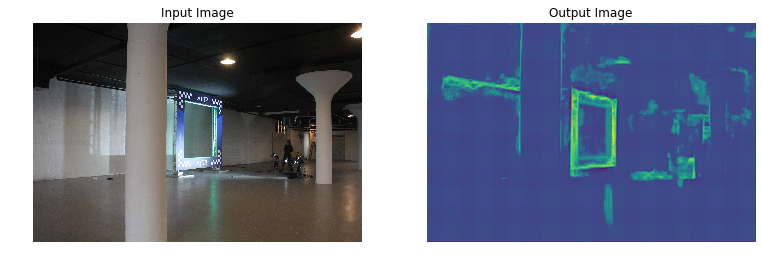

In [36]:
mno = 1 # Should be between 0 - n-1 | where n is the number of classes

figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Output Image')
plt.axis('off')
plt.imshow(out2[mno, :, :])
plt.show()

In [37]:
b_ = out1.data.max(0)[1].cpu().numpy()

In [38]:
def decode_segmap(image):
    gate = [128, 128, 128]
     

    label_colours = np.array([gate]).astype(np.uint8)
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, 1):
        r[image == l] = label_colours[l, 0]
        g[image == l] = label_colours[l, 1]
        b[image == l] = label_colours[l, 2]

    rgb = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
    rgb[:, :, 0] = b
    rgb[:, :, 1] = g
    rgb[:, :, 2] = r
    return rgb


In [39]:
true_seg = decode_segmap(final_mask)
pred_seg = decode_segmap(b_)

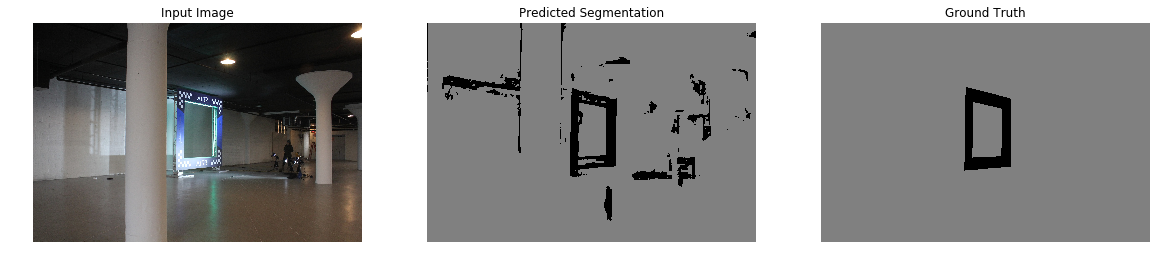

In [40]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Predicted Segmentation')
plt.axis('off')
plt.imshow(pred_seg)
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(true_seg)
plt.show()

# Training pipeline

# Post-processing pipeline      

In [ ]:
start = time.time()
training_gen = generate_train_batch(cars_15_35GB,1)
batch_img,batch_mask = next(training_gen)
end = time.time()
end-start

In [ ]:
start = time.time()
sample_imgs=1 
testing_gen = generate_test_batch(cars_15_35GB,sample_imgs)
pre_final_predictions= model.predict(batch_img)
end = time.time()
end-start

In [ ]:
### Test on last frames of data
start = time.time()
batch_img,batch_mask = next(testing_gen)
pre_final_predictions= model.predict(batch_img)
np.shape(pre_final_predictions)
for i in range(sample_imgs):
    im=batch_img[i]
    pred,im = next_img(im)
    im  = np.array(im,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    img_true = cv2.addWeighted(rgb_mask_true,0.70,im,0.70,0)
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.70,im,1,0)
    draw_img = get_BB_new_img(im)
    plt.figure(figsize=(14,5))
    plt.subplot(1,4,1)
    plt.imshow(im)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(img_pred)
    plt.title('Segmented')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(draw_img)
    plt.title('Predicted')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(img_true)
    plt.title('Gtruth')
    plt.axis('off')

end = time.time()
end-start   

In [ ]:
test_img = 'scene01021.jpg'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
pred,im = next_img(im)
im  = np.array(im,dtype= np.uint8)
im_pred = np.array(255*pred[0],dtype=np.uint8)
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]

img_pred = cv2.addWeighted(rgb_mask_pred,0.70,im,1,0)

draw_img = get_BB_new_img(im)

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Segmentated')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(draw_img)
plt.title('Bounding Box')
plt.axis('off');



## Performing camera calibration
Camera calibration is performed in order to correct the deformation in the images that is caused to the optic lens curvature. The first step is to print a chessboard and take random pictures of it. Then count the chess intersecting squires to provide "objp" which holds the (x,y,z) coordinates of these corners. Z=0 here and the object points are the same for all images in the calibration folder. The objpoints will be appended in "objp" every time the method successfully detect all chessboard corners in a test image. "imgpoints" will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.
"objpoints" and "imgpoints" were used to compute the camera calibration and distortion coefficients using the "cv2.calibrateCamera()" function on a test image in "cv2.undistort()"

In [ ]:
# prepare object points. The number of corners are 6x9
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images, all located in camera_cal
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # imread reads images in BGR format
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
#cv2.destroyAllWindows()

## Perform distortion removal on test images¶
1. Has the distortion correction been correctly applied to each image?
Undistortion is performed on the provided test images before they are used in the pipeline. This also applies to the video frames. "dst" holds undistorted frames from "cv2.undistort" that were computed using "mtx".

In [ ]:
for image_name in glob.glob("Frames/*"):
    im = cv2.imread(image_name)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = undistort(im,read=False, display = False, write = False)
    pred,im = next_img(im)
    im  = np.array(im,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.50,im,1,0)
    draw_img = get_BB_new_img(im)
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Segmentated')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(draw_img)
    plt.title('Bounding Box')
    plt.axis('off');

heatmap_10 = [np.zeros((640,960))]*10
    

In [ ]:
def video_pipeline(image):
    #test_img = 'scene01021.jpg'
    #im = cv2.imread(im)
    #im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    #img = get_BB_new_img(im)
    # Apply bounding box to image
    image_bb = np.copy(image)
    bbox_cars = get_BB_new(image_bb)
    img_size = np.shape(image)
    result = image
    img_res_shape = result.shape
    for bbox in bbox_cars:
        cv2.rectangle(result,(np.int32(bbox[0][0]*img_res_shape[1]/960),np.int32(bbox[0][1]*img_res_shape[0]/640)), (np.int32(bbox[1][0]*img_res_shape[1]/960),np.int32(bbox[1][1]*img_res_shape[0]/640)),(0,255,0),6)
    #heatmap = get_Unet_mask(image_bb)
    #plt.imshow(img)
    return result

In [ ]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline) 
white_clip.write_videofile(video_output, audio=False)

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))